In [ ]:
from google.colab import files
uploaded=files.upload()

Saving DENV4.fasta to DENV4.fasta
Saving DENV1.fasta to DENV1.fasta
Saving DENV2.fasta to DENV2.fasta
Saving DENV3.fasta to DENV3.fasta


In [ ]:
import os
print(os.listdir('/content'))



['.config', 'DENV2.fasta', 'DENV4.fasta', 'DENV3.fasta', 'DENV1.fasta', 'sample_data']


In [ ]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.1 MB/s eta 0:00:00


In [ ]:
import os
from Bio import SeqIO
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np


folder_path = "/content"

# Label mapping
label_map = {
    "DENV1": 0,
    "DENV2": 1,
    "DENV3": 2,
    "DENV4": 3,
}

# Extract sequences and labels
data = []
for file in os.listdir(folder_path):
    if file.endswith(".fasta") or file.endswith(".fa"):
        for serotype in label_map:
            if serotype in file.upper():
                label = label_map[serotype]
                break
        else:
            continue

        filepath = os.path.join(folder_path, file)
        for record in SeqIO.parse(filepath, "fasta"):
            sequence = str(record.seq).upper()
            data.append([sequence, label])

# Create DataFrame
df = pd.DataFrame(data, columns=["sequence", "label"])
print("Sample data:")
print(df.head())
print(f"Total samples: {len(df)}")


Sample data:
                                            sequence  label
0  ---------------AAAAAGGCGAGAAATACGCCTTTCAATATGC...      1
1  ATGAATAACCAACGGAAAAAGGCGAGAAACACGCCTTTCAATATGC...      1
2  ATGAATAACCAACGGAAAAAGGCGAGAAACACGCCTTTCAATATGC...      1
3  ATGAATAACCAACGGAAAAAGGCGAGAAACACGCCTTTCAATATGC...      1
4  ATGAATAACCAACGGAAAAAGGCGAGAAACACGCCTTTCAATATGC...      1
Total samples: 5992


In [ ]:
print("Label distribution:", df['label'].value_counts())



Label distribution: label
0    2416
1    1955
2    1202
3     419
Name: count, dtype: int64


In [ ]:
# ===== STEP 0: Imports =====
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf

# ===== Set Random Seeds for Reproducibility =====
np.random.seed(42)
tf.random.set_seed(42)

# ===== STEP 1: DNA Sequence Encoding Function =====
def encode_sequence(seq):
    mapping = {'A': 1, 'C': 2, 'G': 3, 'T': 4}
    return [mapping.get(base, 0) for base in seq]

# ===== STEP 2: Load and Encode Dataset =====
# df = pd.read_csv('your_dataset.csv')  # Uncomment if loading from CSV
df['encoded'] = df['sequence'].apply(encode_sequence)

# ===== STEP 3: Pad Sequences =====
MAX_LEN = 1000
X = pad_sequences(df['encoded'], maxlen=MAX_LEN, padding='post')
X = np.array(X, dtype=np.int32)

# ===== STEP 4: Labels =====
y = df['label'].values

# ===== STEP 5: Split Dataset =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===== STEP 6: Compute Class Weights =====
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))



Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.4322 - loss: 1.2150 - val_accuracy: 0.8425 - val_loss: 0.3462
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.8965 - loss: 0.2383 - val_accuracy: 0.9885 - val_loss: 0.0277
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9829 - loss: 0.0472 - val_accuracy: 0.9979 - val_loss: 0.0110
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9916 - loss: 0.0297 - val_accuracy: 0.9979 - val_loss: 0.0090
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.9953 - loss: 0.0159 - val_accuracy: 0.9979 - val_loss: 0.0099
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step
              precision    recall  f1-score   support

           0     1.0000    0.9958    0.9979       477
           1     0.9882    1.0000    0.9941       420
           2     0.9954    0.9864    0.9909       220
           3     1.0000    0.9878    0.9939        82

    accuracy                         0.9950      1199
  

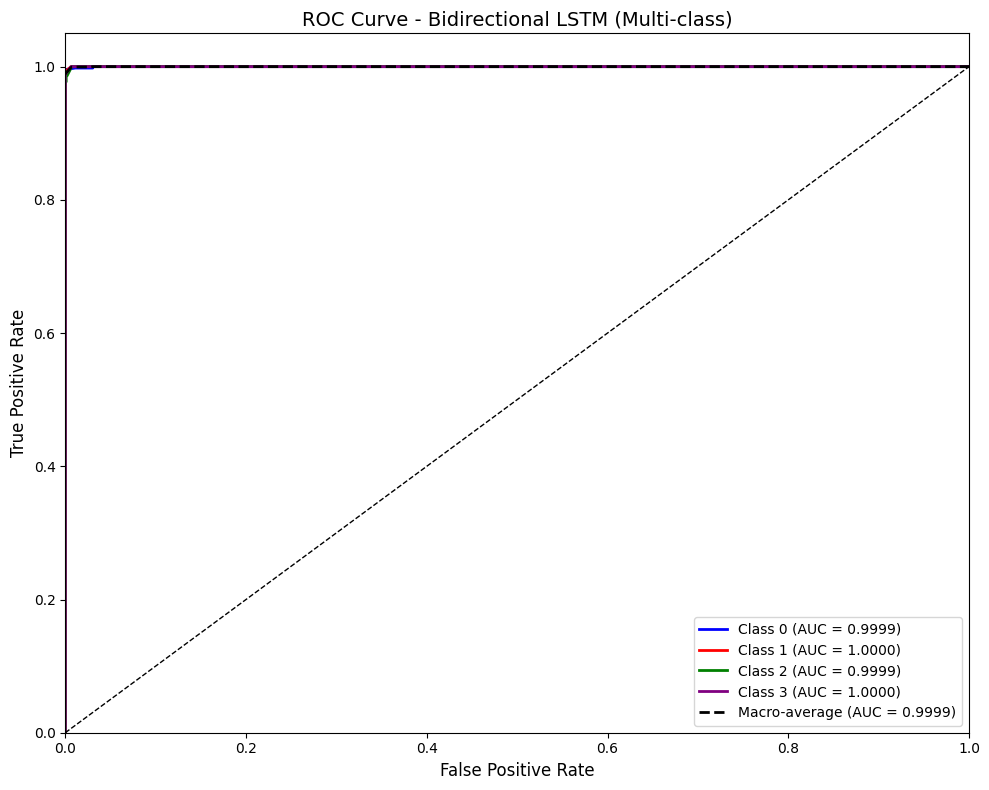

In [ ]:
# =====  Bidirectional LSTM Model =====
model = Sequential([
    Embedding(input_dim=5, output_dim=128),
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# ===== STEP 8: Compile Model =====
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ===== STEP 9: Train Model with EarlyStopping (max 5 epochs) =====
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=5,  # Reduced to 5 epochs for regularization
    batch_size=64,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

# ===== STEP 10: Predict and Evaluate =====
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test, y_pred, digits=4))

# ===== STEP 11: Compute ROC curves for each class =====
# Binarize the true labels for ROC calculation
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1] # Get the number of classes

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    # Use the predicted probabilities for class i
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ===== STEP 12: Compute Macro-average ROC =====
# Aggregate all False Positive Rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at these points and average
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    # Interpolate tpr at the aggregated fpr points
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average the tpr
mean_tpr /= n_classes

# Compute the Macro-average AUC
macro_auc = auc(all_fpr, mean_tpr)


# ===== STEP 13: Plot ROC Curves (Without Grid) =====
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple'] # Define colors for classes
# Plot each class's ROC curve
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.4f})')

# Plot macro-average ROC curve
plt.plot(all_fpr, mean_tpr, color='black', linestyle='--', lw=2,
         label=f'Macro-average (AUC = {macro_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1) # Plot the random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Bidirectional LSTM (Multi-class)', fontsize=14)
plt.legend(loc='lower right')
# Grid removed as requested
plt.tight_layout()
plt.show()

Random Forest

📊 Classification Report:
              precision    recall  f1-score   support

      DENV-1       1.00      1.00      1.00       477
      DENV-2       0.99      1.00      0.99       420
      DENV-3       1.00      0.98      0.99       220
      DENV-4       1.00      0.99      0.99        82

    accuracy                           0.99      1199
   macro avg       1.00      0.99      0.99      1199
weighted avg       1.00      0.99      0.99      1199



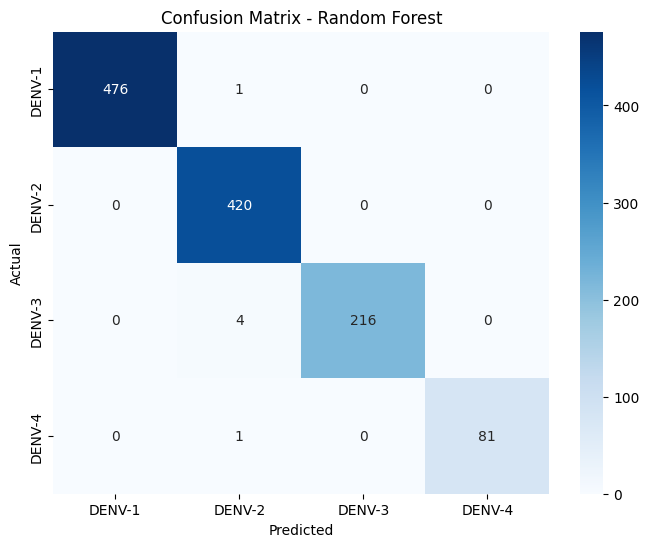

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 2. Predict on test set
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)

# 3. Classification report (overall + per class)
class_names = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# 4. Confusion Matrix (overall)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# 5. ROC Curve (multi-class)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
colors = ['blue', 'green', 'orange', 'red']

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)



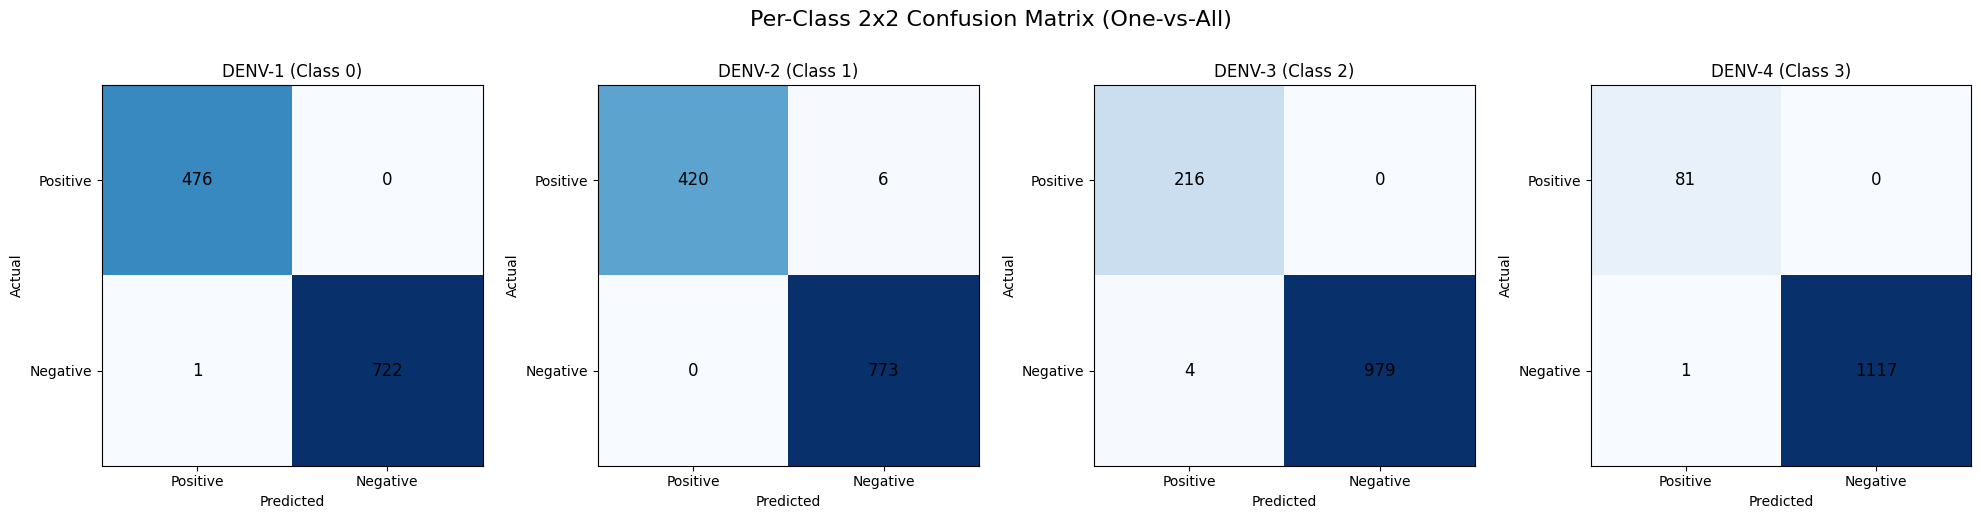

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute overall multi-class confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3])
class_names = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']

# Create subplots for each class
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, ax in enumerate(axes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    binary_cm = np.array([[TP, FP],
                          [FN, TN]])

    im = ax.imshow(binary_cm, cmap='Blues')
    ax.set_title(f'{class_names[i]} (Class {i})')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['Positive', 'Negative'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    # Annotate each cell
    for j in range(2):
        for k in range(2):
            ax.text(k, j, str(binary_cm[j, k]), va='center', ha='center', fontsize=12, color='black')

fig.suptitle('Per-Class 2x2 Confusion Matrix (One-vs-All)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()



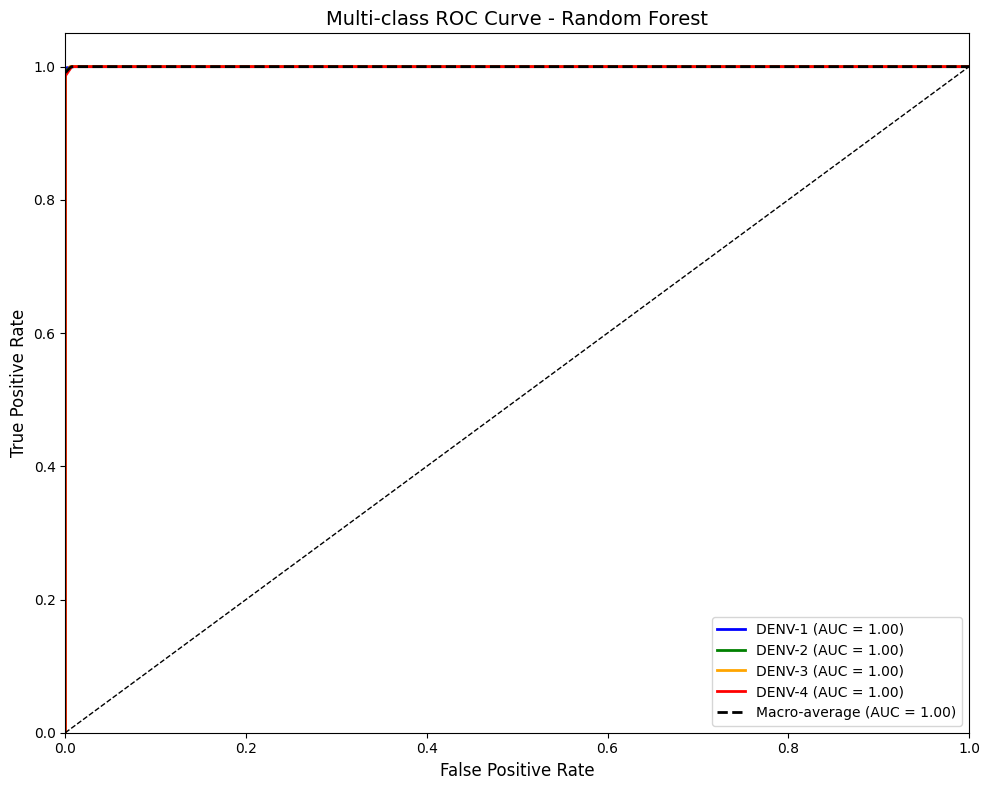

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)

# Plot ROC curves
class_names = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']
colors = ['blue', 'green', 'orange', 'red']

plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot macro-average
plt.plot(all_fpr, mean_tpr, color='black', linestyle='--', lw=2,
         label=f'Macro-average (AUC = {macro_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-class ROC Curve - Random Forest', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


Decission Tree Classifier

=== Decision Tree - Classification Report ===
              precision    recall  f1-score   support

           0     0.9758    1.0000    0.9877       483
           1     1.0000    0.9847    0.9923       391
           2     1.0000    0.9751    0.9874       241
           3     1.0000    1.0000    1.0000        84

    accuracy                         0.9900      1199
   macro avg     0.9939    0.9899    0.9918      1199
weighted avg     0.9902    0.9900    0.9900      1199



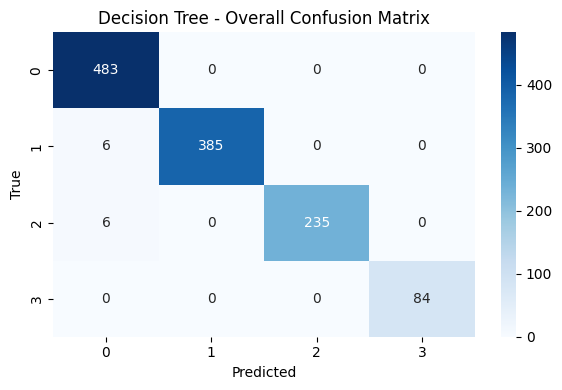

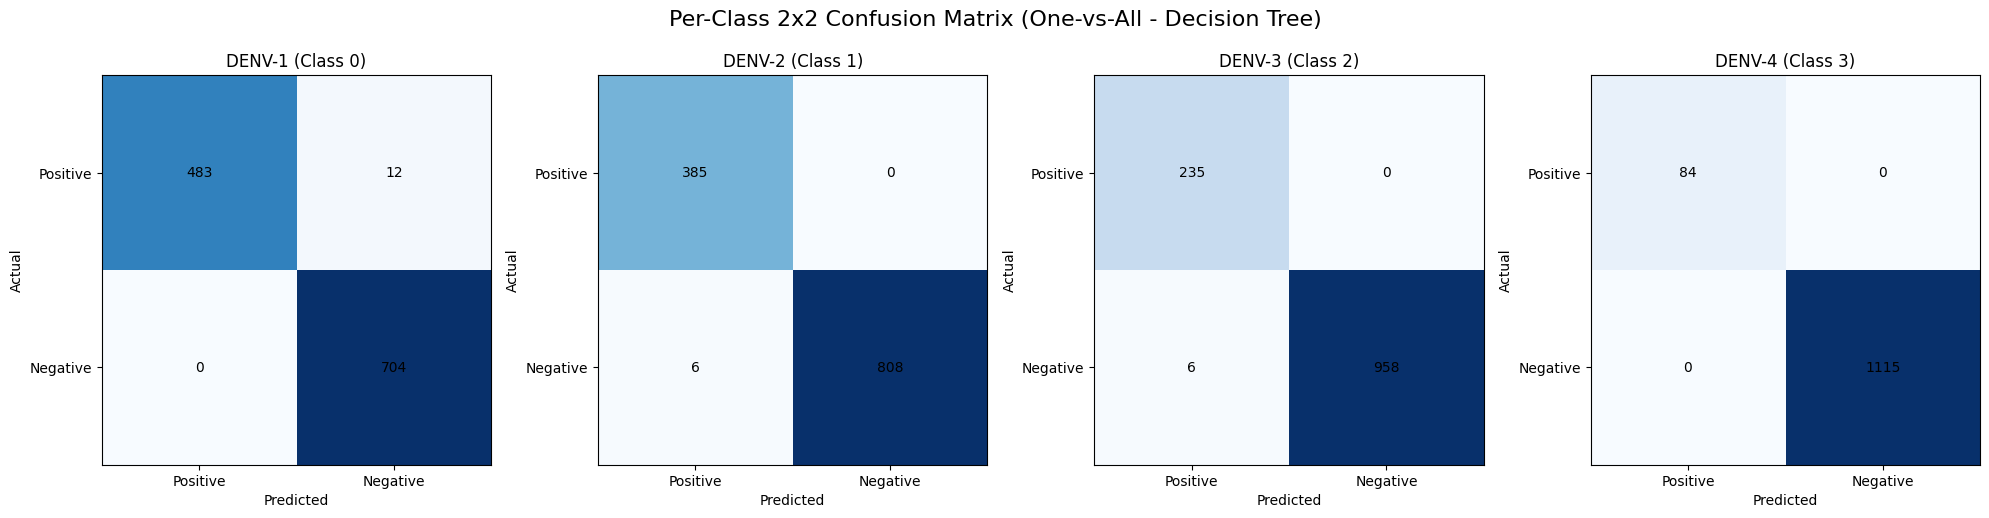

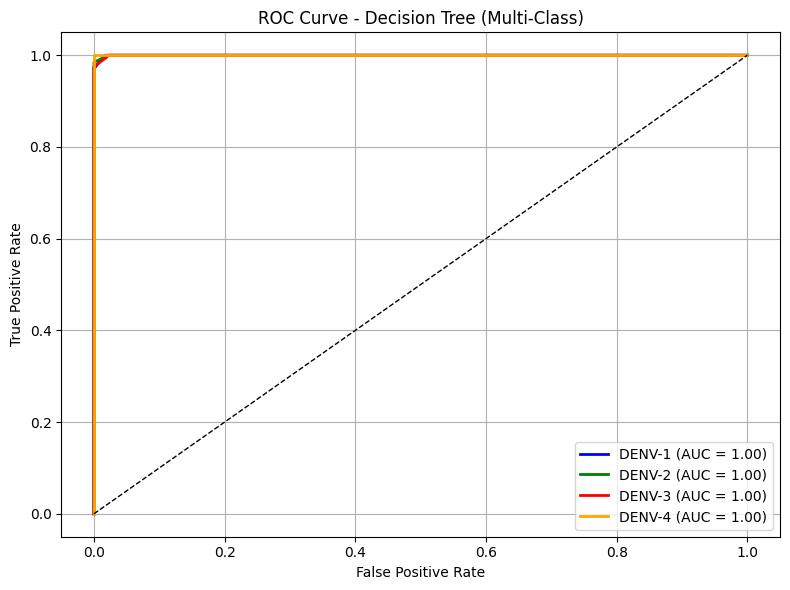

In [ ]:
# === STEP 1: Imports ===
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns # Import seaborn for confusion matrix plotting
# Import train_test_split to ensure X_train and X_test are correctly generated
from sklearn.model_selection import train_test_split


# --- Assume X_manual and y are available from the previous data preprocessing step (cell 70) ---
# (Where sequences were tokenized and padded to max_len = 100)
# If running this cell independently, you would need to re-run the preprocessing cells
# to create X_manual and y.

# === Re-split the data using the padded sequences ===
# This ensures X_train, X_test, y_train, y_test match the padded format
X_train, X_test, y_train, y_test = train_test_split(X_manual, y, test_size=0.2, stratify=y, random_state=42)


# === STEP 2: Train Decision Tree Model ===
# Use the X_train and y_train from the NEW split
dt_model = DecisionTreeClassifier(max_depth=8, min_samples_split=5, random_state=42)
dt_model.fit(X_train, y_train)

# === STEP 3: Predict ===
# Use the X_test from the NEW split
y_pred = dt_model.predict(X_test)
y_pred_probs = dt_model.predict_proba(X_test)

# === STEP 4: Classification Report ===
print("=== Decision Tree - Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

# === STEP 5: Overall Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
# Use unique labels from y_test for axis ticks
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Decision Tree - Overall Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# === STEP 6: 2x2 Confusion Matrix for Each Class ===
class_names = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4'] # Define class names

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, ax in enumerate(axes):
    # Use the multi-class cm to extract TP, FP, FN, TN
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    binary_cm = np.array([[TP, FP],
                          [FN, TN]])

    im = ax.imshow(binary_cm, cmap='Blues')
    ax.set_title(f'{class_names[i]} (Class {i})')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['Positive', 'Negative'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    for j in range(2):
        for k in range(2):
            ax.text(k, j, binary_cm[j, k], ha='center', va='center', color='black')

fig.suptitle('Per-Class 2x2 Confusion Matrix (One-vs-All - Decision Tree)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# === STEP 7: ROC Curve ===
# Ensure y_test_bin is created using the actual unique classes present in y_test
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
fpr = {}
tpr = {}
roc_auc = {}
n_classes = y_test_bin.shape[1] # Get number of classes from the binarized array

# Ensure colors list matches the number of classes
colors = ['blue', 'green', 'red', 'orange'][:n_classes]
# Ensure class_names list matches the number of classes
class_names_subset = class_names[:n_classes]


for i in range(n_classes):
    # Use the predicted probabilities for class i
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
# Use class_names_subset for legend labels
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'{class_names_subset[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (Multi-Class)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns # Import seaborn for confusion matrix plotting
from sklearn.model_selection import train_test_split # Import train_test_split

# --- Assume X_manual and y are available from the previous data preprocessing step (cell 70) ---
# (Where sequences were tokenized and padded to max_len = 100)
# If running this cell independently, you would need to re-run the preprocessing cells
# to create X_manual (the padded sequences) and y (the labels).

# === Re-split the data using the padded sequences X_manual ===
# This ensures X_train, X_test, y_train, y_test match the padded format
# Assuming X_manual and y are available from a previous cell where padding to max_len=100 occurred
X_train, X_test, y_train, y_test = train_test_split(X_manual, y, test_size=0.2, stratify=y, random_state=42)


# Train the model
gb_model = GradientBoostingClassifier(random_state=42)
# Use the correctly split and padded X_train
gb_model.fit(X_train, y_train)

# Predict
# Use the correctly split and padded X_test for prediction
gb_pred = gb_model.predict(X_test)
gb_pred_prob = gb_model.predict_proba(X_test)

# Evaluation
print("Classification Report (Gradient Boosting):")
print(classification_report(y_test, gb_pred, digits=4))

Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

           0     0.9777    1.0000    0.9887       483
           1     1.0000    0.9847    0.9923       391
           2     1.0000    0.9793    0.9895       241
           3     1.0000    1.0000    1.0000        84

    accuracy                         0.9908      1199
   macro avg     0.9944    0.9910    0.9926      1199
weighted avg     0.9910    0.9908    0.9908      1199



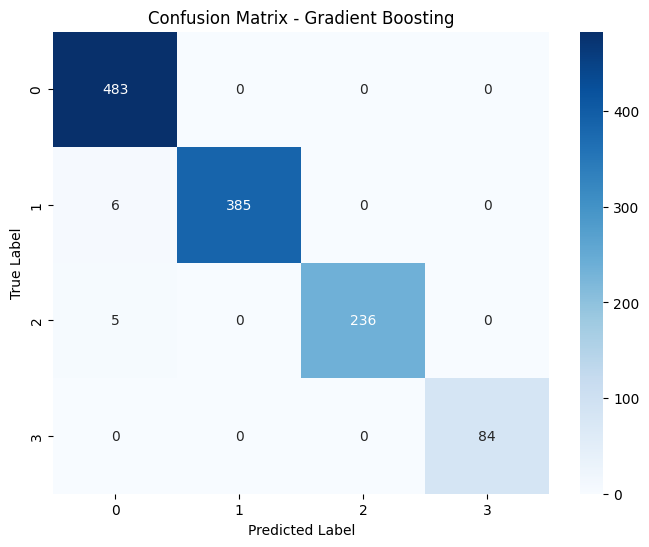

In [ ]:
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, gb_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix - Gradient Boosting')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


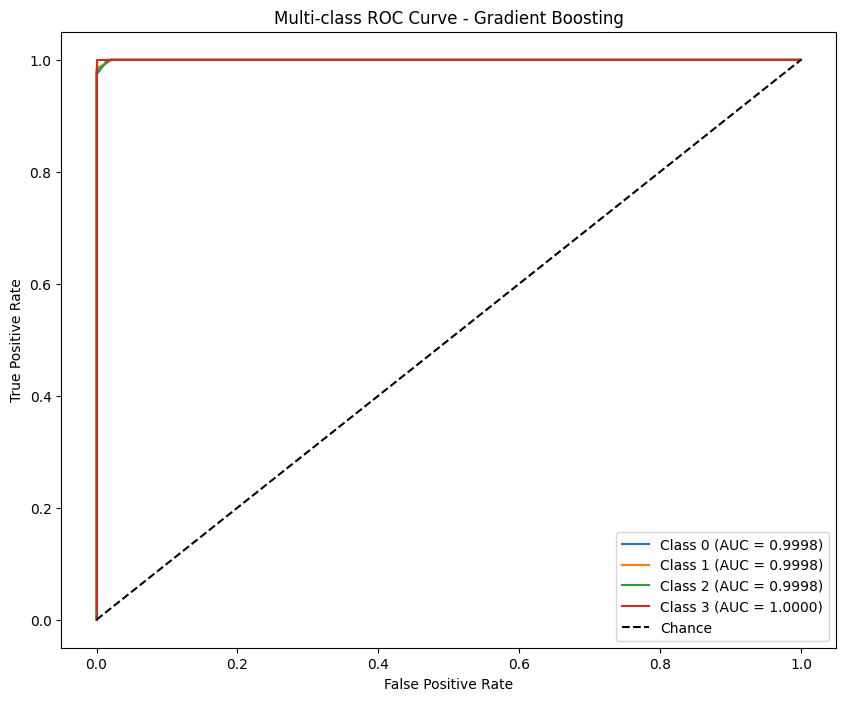

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binarize the labels (for multi-class)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], gb_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {np.unique(y_test)[i]} (AUC = {roc_auc[i]:.4f})")

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title('Multi-class ROC Curve - Gradient Boosting')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


XGBoost Classifier

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:36:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report (XGBoost):
              precision    recall  f1-score   support

           0     1.0000    0.9959    0.9979       483
           1     0.9874    1.0000    0.9936       391
           2     1.0000    0.9876    0.9937       241
           3     1.0000    1.0000    1.0000        84

    accuracy                         0.9958      1199
   macro avg     0.9968    0.9959    0.9963      1199
weighted avg     0.9959    0.9958    0.9958      1199



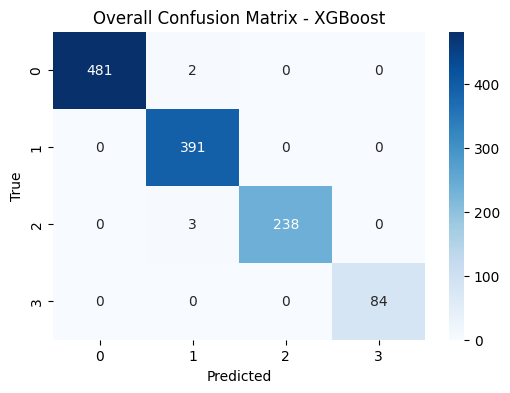

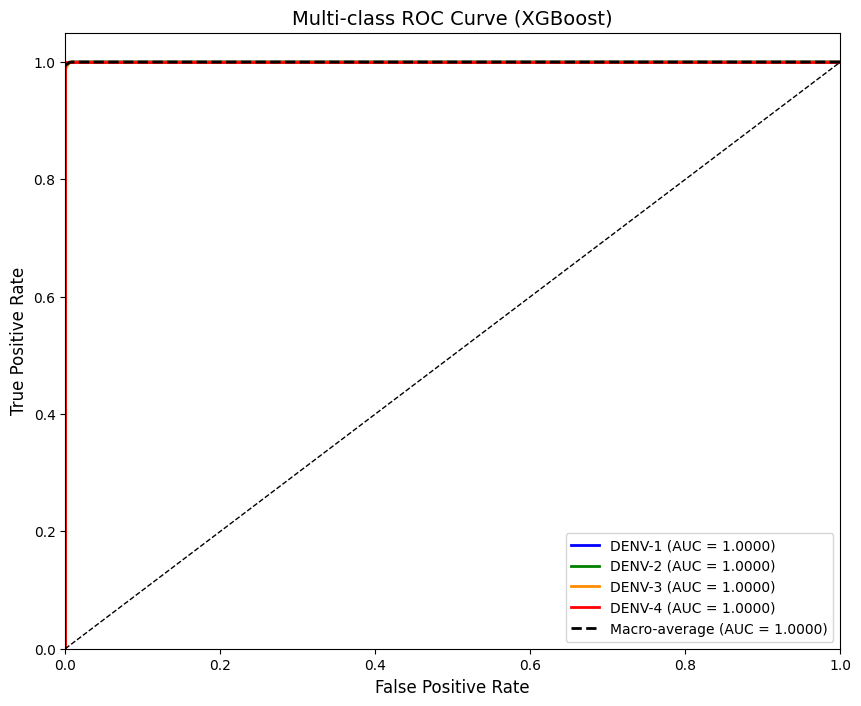

In [ ]:
# Import required libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Split data (assuming X is defined from a previous cell with padding)
# Use the correct variable name 'X' instead of 'X_manual'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# XGBoost classifier with probability output
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',         # Required for probabilistic output
    num_class=len(np.unique(y)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Train model
xgb_model.fit(X_train, y_train)

# Predict classes and probabilities
y_pred = xgb_model.predict(X_test)
y_pred_probs = xgb_model.predict_proba(X_test)

# Print classification report
print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)


# Plot overall Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Overall Confusion Matrix - XGBoost")
plt.show()



# Binarize labels for ROC computation
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# ROC curve per class
fpr, tpr, roc_auc = {}, {}, {}
colors = ['blue', 'green', 'darkorange', 'red'][:n_classes]
class_names = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4'][:n_classes]

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.4f})")

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)
plt.plot(all_fpr, mean_tpr, 'k--', lw=2, label=f"Macro-average (AUC = {macro_auc:.4f})")

# Plot aesthetics
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-class ROC Curve (XGBoost)', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(False)  # No grid, as requested
plt.show()

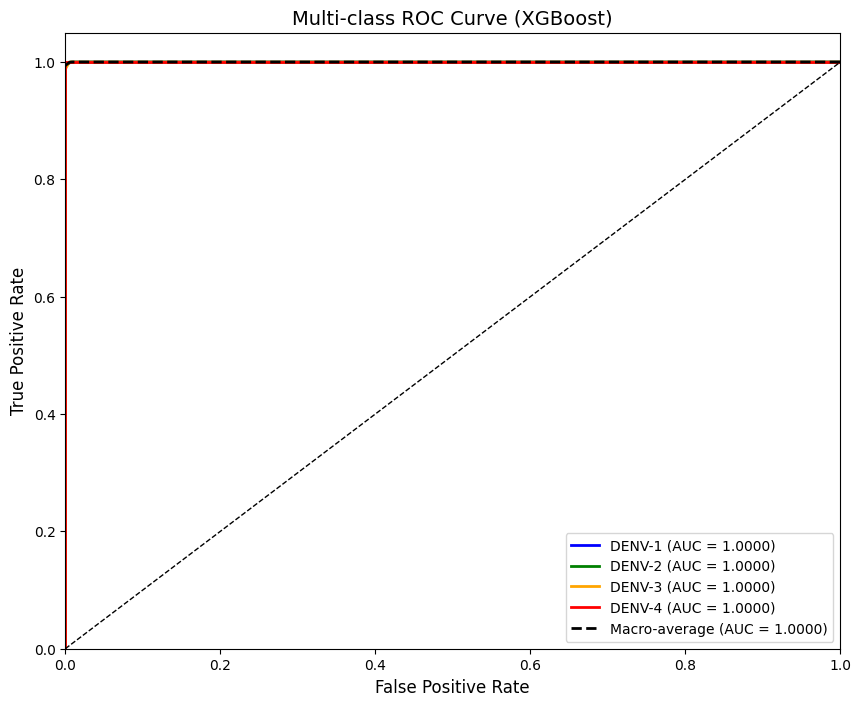

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Ensure labels are binarized correctly
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Get predicted probabilities for each class
y_pred_probs = xgb_model.predict_proba(X_test)

# Calculate FPR, TPR, and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)

# Plotting
colors = ['blue', 'green', 'orange', 'red'][:n_classes]
class_names = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4'][:n_classes]

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot(all_fpr, mean_tpr, 'k--', lw=2, label=f'Macro-average (AUC = {macro_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# Final touches
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-class ROC Curve (XGBoost)', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(False)  # Remove grid
plt.show()


Ridge Classifier

In [ ]:
# ===== STEP 0: Imports =====
import os
import numpy as np
import pandas as pd
from Bio import SeqIO
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import tensorflow as tf

# ===== Reproducibility =====
np.random.seed(42)
tf.random.set_seed(42)

# ===== STEP 1: Load and Label FASTA Sequences =====
folder_path = "/content"
label_map = {"DENV1": 0, "DENV2": 1, "DENV3": 2, "DENV4": 3}
data = []

for file in os.listdir(folder_path):
    if file.endswith(".fasta") or file.endswith(".fa"):
        for serotype in label_map:
            if serotype in file.upper():
                label = label_map[serotype]
                break
        else:
            continue

        filepath = os.path.join(folder_path, file)
        for record in SeqIO.parse(filepath, "fasta"):
            sequence = str(record.seq).upper()
            data.append([sequence, label])

df = pd.DataFrame(data, columns=["sequence", "label"])
print("Sample data:\n", df.head())
print("Total samples loaded:", len(df))

# ===== STEP 2: Encode Sequences =====
def encode_sequence(seq):
    mapping = {'A': 1, 'C': 2, 'G': 3, 'T': 4}
    return [mapping.get(base, 0) for base in seq]

df['encoded'] = df['sequence'].apply(encode_sequence)

# ===== STEP 3: Pad Sequences =====
MAX_LEN = 1000
X = pad_sequences(df['encoded'], maxlen=MAX_LEN, padding='post')
y = df['label'].values

print(f"X shape: {X.shape}")  # Should be (5992, 1000)
print(f"y shape: {y.shape}")  # Should be (5992,)

# ===== STEP 4: Train-Test Split =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ===== STEP 5: Compute Class Weights =====
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))





Sample data:
                                             sequence  label
0  ATGAACAACCAACGGAAAAAGACGGGTCGACCGTCTTTCAATATGC...      0
1  ATGAACAACCAACGAAAAAAGACGGGTCGACCGTCTTTCAATATGC...      0
2  ATGAACAACCAACGGAAAAAGACGGGTCGACCGTCTTTCAATATGC...      0
3  ATGAACAACCAACGGAAAAAGACGGGTCGACCGTCTTTCAATATGC...      0
4  ATGAACAACCAACGGAAAAAGACGGGTCGACCGTCTTTCAATATGC...      0
Total samples loaded: 5992
X shape: (5992, 1000)
y shape: (5992,)


In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# STEP 1: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# STEP 2: Initialize and train the Ridge Classifier
ridge = RidgeClassifier()
ridge.fit(X_train, y_train)

# STEP 3: Predict
y_pred = ridge.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))




Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9959    0.9979       483
           1     0.9874    1.0000    0.9936       391
           2     1.0000    0.9876    0.9937       241
           3     1.0000    1.0000    1.0000        84

    accuracy                         0.9958      1199
   macro avg     0.9968    0.9959    0.9963      1199
weighted avg     0.9959    0.9958    0.9958      1199



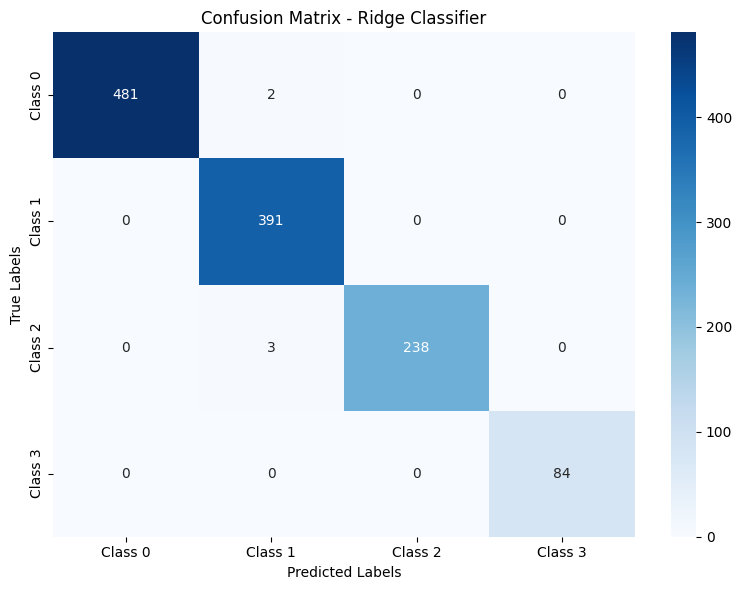

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# STEP 4.1: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Class {i}" for i in np.unique(y)],
            yticklabels=[f"Class {i}" for i in np.unique(y)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Ridge Classifier')
plt.tight_layout()
plt.show()


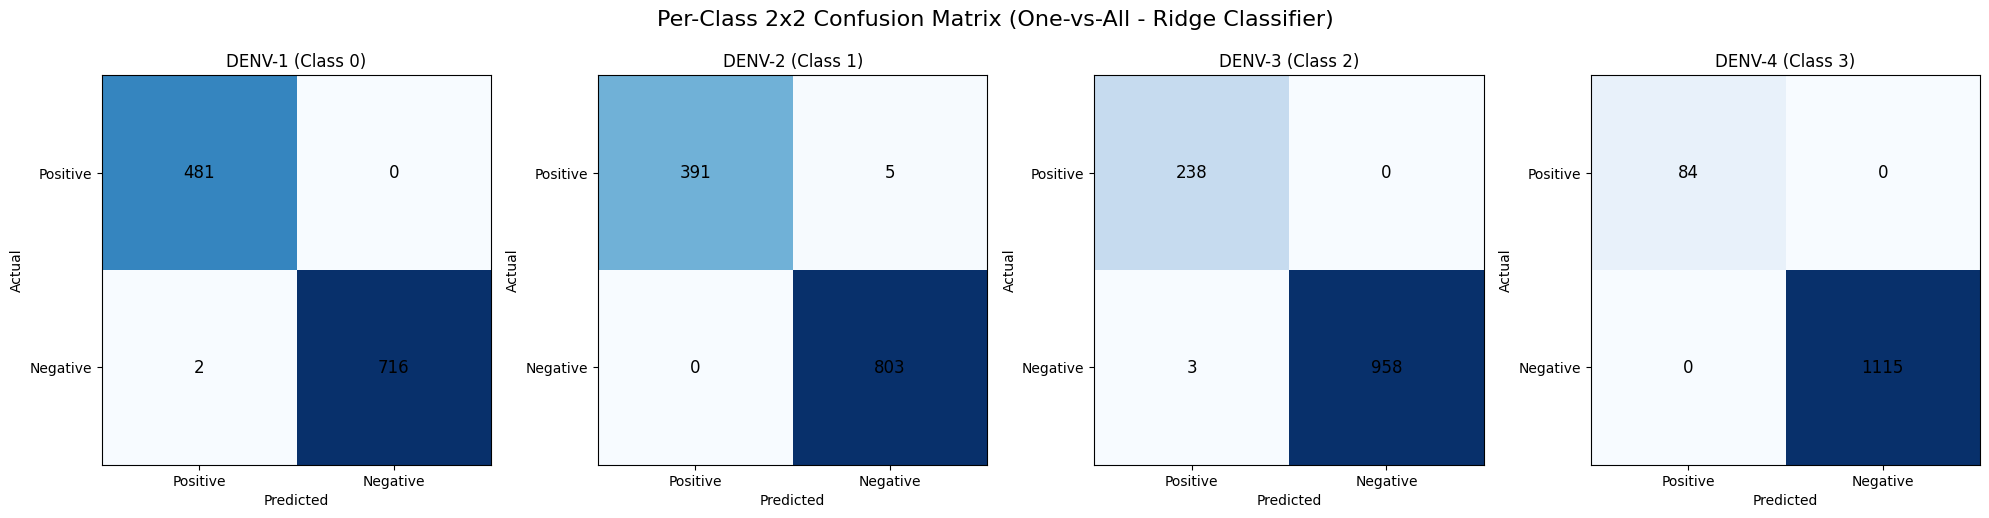

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Class labels
class_names = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, ax in enumerate(axes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    binary_cm = np.array([[TP, FP],
                          [FN, TN]])

    im = ax.imshow(binary_cm, cmap='Blues')
    ax.set_title(f'{class_names[i]} (Class {i})')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['Positive', 'Negative'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    for j in range(2):
        for k in range(2):
            ax.text(k, j, binary_cm[j, k], ha='center', va='center', color='black', fontsize=12)

fig.suptitle('Per-Class 2x2 Confusion Matrix (One-vs-All - Ridge Classifier)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


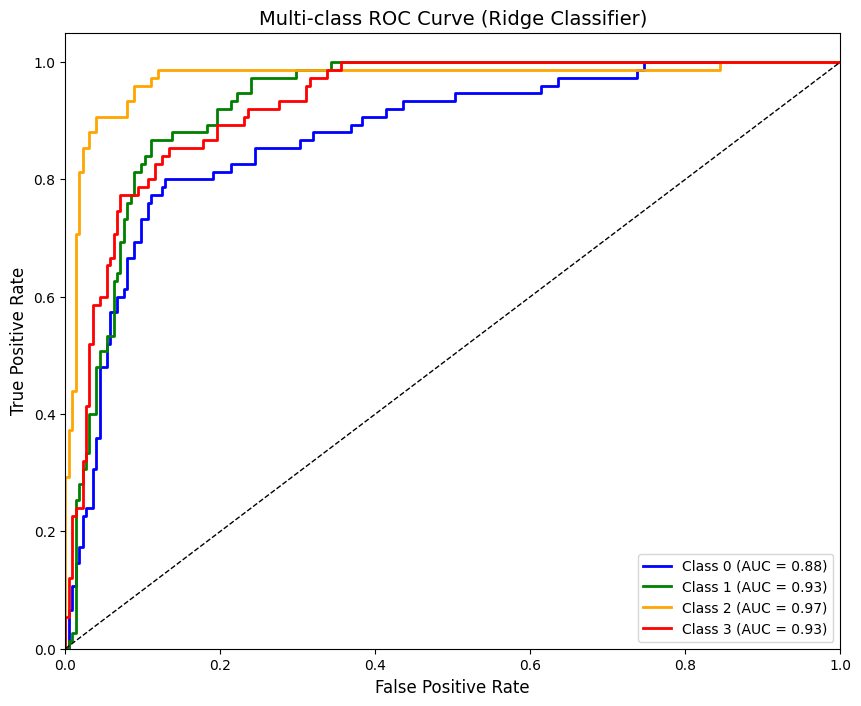

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import make_pipeline

# Step 1: Generate synthetic multi-class data
X, y = make_classification(n_samples=1000, n_classes=4, n_informative=6,
                           n_clusters_per_class=1, n_redundant=0,
                           random_state=42)

# Step 2: Binarize the output
y_bin = label_binarize(y, classes=[0, 1, 2, 3])
n_classes = y_bin.shape[1]

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.3,
                                                    random_state=42)

# Step 4: Train Ridge Classifier with scaling
clf = make_pipeline(StandardScaler(), RidgeClassifier())
clf.fit(X_train, y_train)

# Step 5: Get decision scores (not probabilities)
y_score = clf.decision_function(X_test)

# Binarize y_test for ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

# Step 6: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 7: Plot ROC curves (without grid)
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'red']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-class ROC Curve (Ridge Classifier)', fontsize=14)
plt.legend(loc="lower right")
plt.show()


naive Bayes

In [ ]:

import os
import numpy as np
import pandas as pd
from Bio import SeqIO
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# ===== Rebuild Data =====
folder_path = "/content"  # change to your fasta folder path
label_map = {"DENV1": 0, "DENV2": 1, "DENV3": 2, "DENV4": 3}
data = []

for file in os.listdir(folder_path):
    if file.endswith(".fasta") or file.endswith(".fa"):
        for serotype in label_map:
            if serotype in file.upper():
                label = label_map[serotype]
                break
        else:
            continue

        for record in SeqIO.parse(os.path.join(folder_path, file), "fasta"):
            seq = str(record.seq).upper()
            data.append([seq, label])

df = pd.DataFrame(data, columns=["sequence", "label"])
print(f"Total samples: {len(df)}")

# ===== Encode & Pad =====
def encode(seq):
    return [ {'A':1, 'C':2, 'G':3, 'T':4}.get(base, 0) for base in seq ]

df["encoded"] = df["sequence"].apply(encode)
X = pad_sequences(df["encoded"], maxlen=1000, padding="post")
y = df["label"].values

print("X shape:", X.shape)  # (5992, 1000)
print("y shape:", y.shape)  # (5992,)

# ===== Train/Test Split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ===== Train Naive Bayes =====
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

# ===== Classification Report & Confusion Matrix =====
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))




Total samples: 5992
X shape: (5992, 1000)
y shape: (5992,)

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9938    0.9969       483
           1     0.9849    1.0000    0.9924       391
           2     1.0000    0.9876    0.9937       241
           3     1.0000    1.0000    1.0000        84

    accuracy                         0.9950      1199
   macro avg     0.9962    0.9953    0.9958      1199
weighted avg     0.9951    0.9950    0.9950      1199



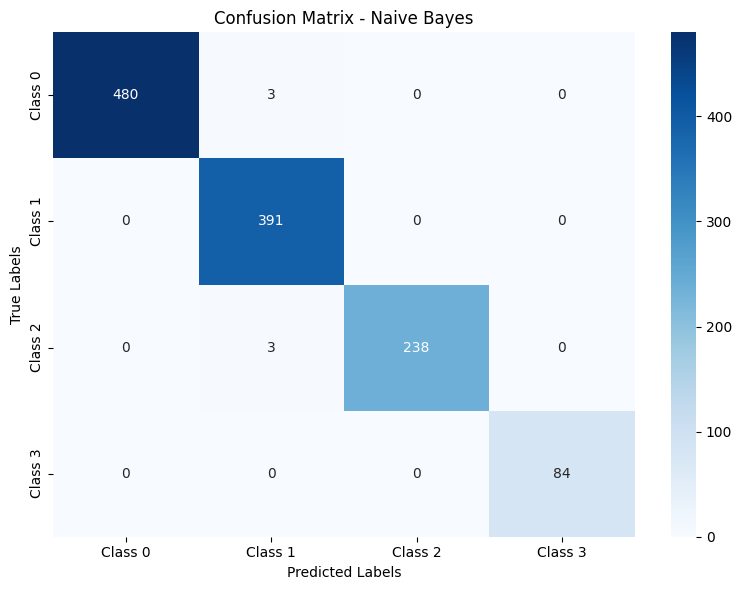

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# STEP 4.1: Confusion Matrix for Naive Bayes
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Class {i}" for i in np.unique(y)],
            yticklabels=[f"Class {i}" for i in np.unique(y)])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Naive Bayes')
plt.tight_layout()
plt.show()


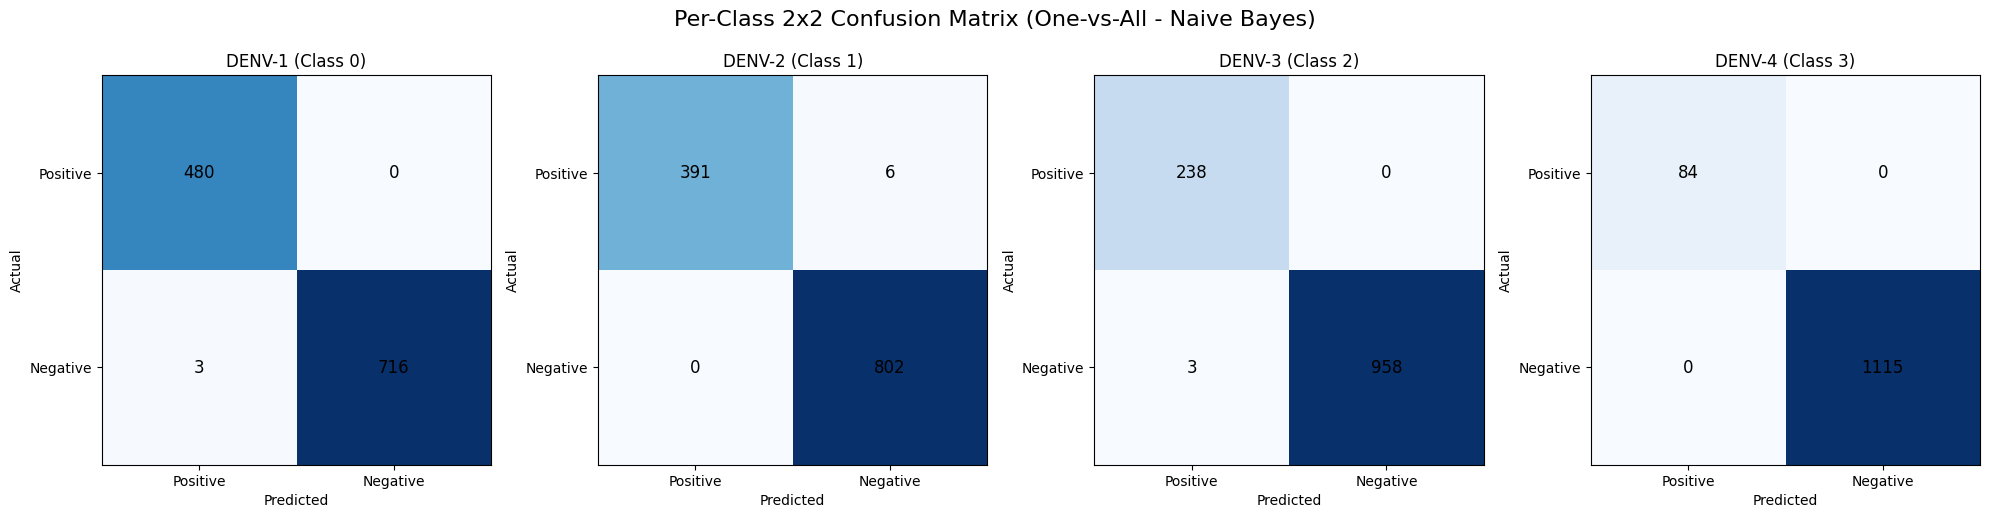

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Class labels (update if you have different class names)
class_names = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']

# Ensure `cm` is the confusion matrix from Naive Bayes predictions
# Example: cm = confusion_matrix(y_test, y_pred)

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, ax in enumerate(axes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    binary_cm = np.array([[TP, FP],
                          [FN, TN]])

    im = ax.imshow(binary_cm, cmap='Blues')
    ax.set_title(f'{class_names[i]} (Class {i})')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['Positive', 'Negative'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    for j in range(2):
        for k in range(2):
            ax.text(k, j, binary_cm[j, k], ha='center', va='center', color='black', fontsize=12)

fig.suptitle('Per-Class 2x2 Confusion Matrix (One-vs-All - Naive Bayes)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


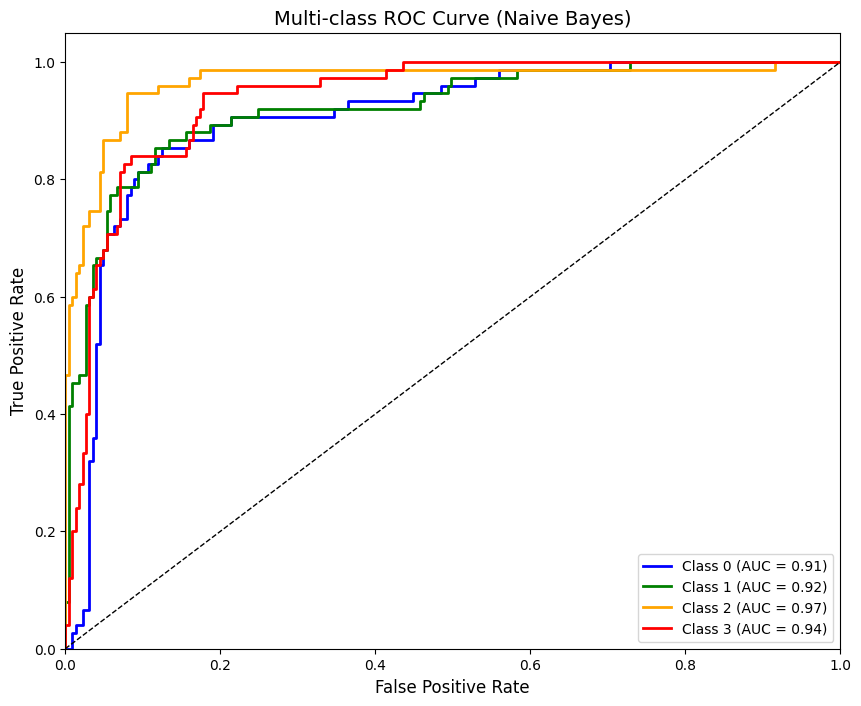

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import make_pipeline

# Step 1: Generate synthetic multi-class data
X, y = make_classification(n_samples=1000, n_classes=4, n_informative=6,
                           n_clusters_per_class=1, n_redundant=0,
                           random_state=42)

# Step 2: Binarize the output
y_bin = label_binarize(y, classes=[0, 1, 2, 3])
n_classes = y_bin.shape[1]

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.3,
                                                    random_state=42)

# Step 4: Train Naive Bayes (with standard scaling)
clf = make_pipeline(StandardScaler(), GaussianNB())
clf.fit(X_train, y_train)

# Step 5: Get predicted probabilities
y_score = clf.predict_proba(X_test)

# Binarize y_test for ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

# Step 6: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 7: Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'red']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-class ROC Curve (Naive Bayes)', fontsize=14)
plt.legend(loc="lower right")
plt.show()


Extra Trees classifier

Total samples: 5992
X shape: (5992, 1000)
y shape: (5992,)

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9959    0.9979       483
           1     0.9874    1.0000    0.9936       391
           2     1.0000    0.9876    0.9937       241
           3     1.0000    1.0000    1.0000        84

    accuracy                         0.9958      1199
   macro avg     0.9968    0.9959    0.9963      1199
weighted avg     0.9959    0.9958    0.9958      1199



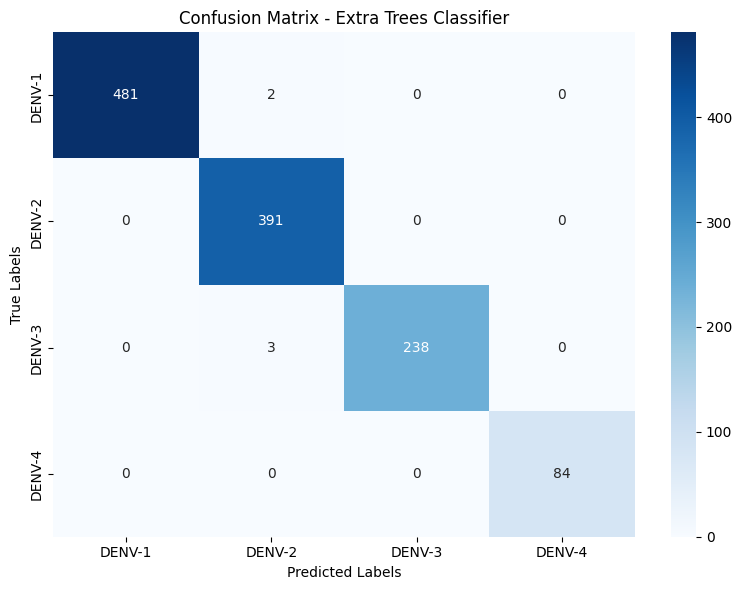

In [ ]:
import os
import numpy as np
import pandas as pd
from Bio import SeqIO
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt

# ===== Load & Encode Sequences =====
folder_path = "/content"  # Update if needed
label_map = {"DENV1": 0, "DENV2": 1, "DENV3": 2, "DENV4": 3}
data = []

for file in os.listdir(folder_path):
    if file.endswith(".fasta") or file.endswith(".fa"):
        for serotype in label_map:
            if serotype in file.upper():
                label = label_map[serotype]
                break
        else:
            continue
        for record in SeqIO.parse(os.path.join(folder_path, file), "fasta"):
            seq = str(record.seq).upper()
            data.append([seq, label])

df = pd.DataFrame(data, columns=["sequence", "label"])
print(f"Total samples: {len(df)}")

# ===== Encode & Pad =====
def encode(seq):
    return [ {'A': 1, 'C': 2, 'G': 3, 'T': 4}.get(base, 0) for base in seq ]

df["encoded"] = df["sequence"].apply(encode)
X = pad_sequences(df["encoded"], maxlen=1000, padding="post")
y = df["label"].values

print("X shape:", X.shape)
print("y shape:", y.shape)

# ===== Train/Test Split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ===== Train Extra Trees Classifier =====
model = ExtraTreesClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# ===== Evaluation =====
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# ===== Confusion Matrix =====
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4'],
            yticklabels=['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Extra Trees Classifier')
plt.tight_layout()
plt.show()


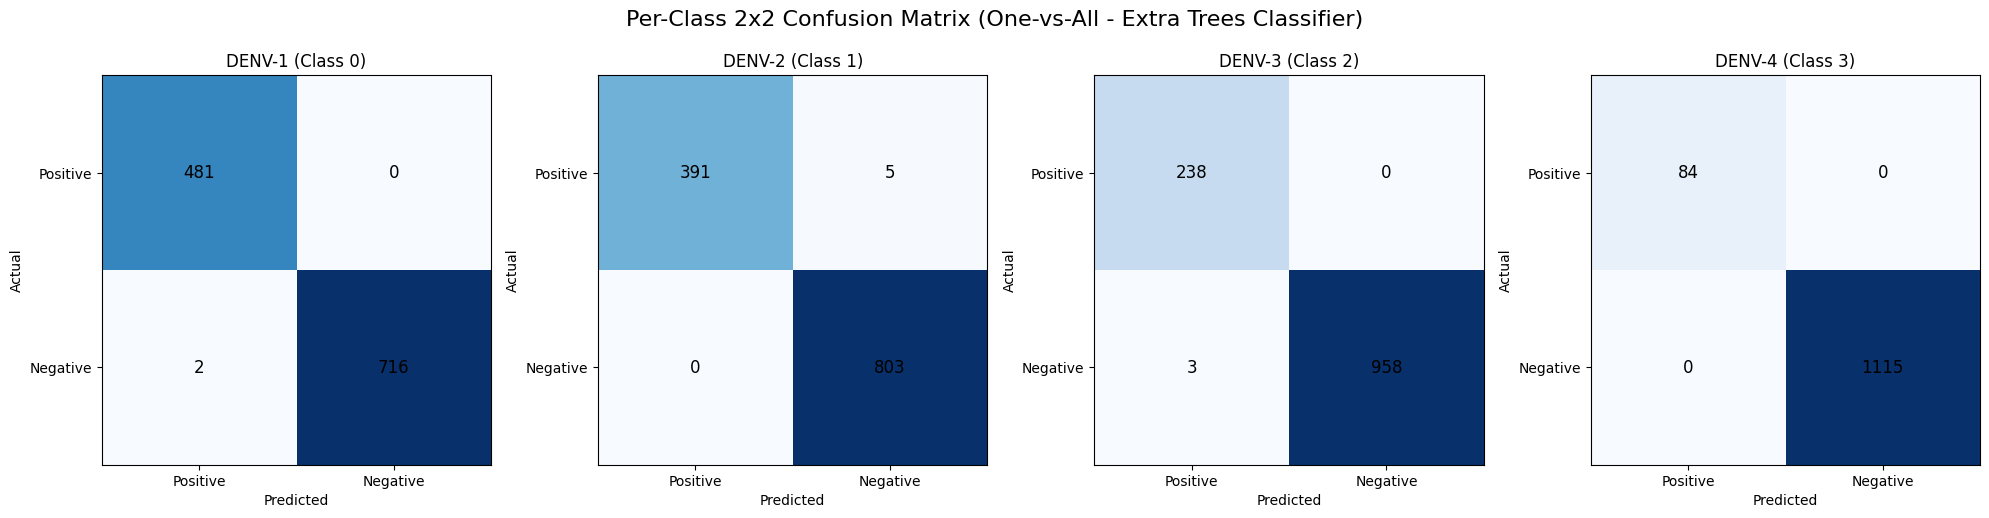

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Ensure these are from Extra Trees predictions
# Example:
# y_pred = model.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)

# Class labels
class_names = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, ax in enumerate(axes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    binary_cm = np.array([[TP, FP],
                          [FN, TN]])

    im = ax.imshow(binary_cm, cmap='Blues')
    ax.set_title(f'{class_names[i]} (Class {i})')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['Positive', 'Negative'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    for j in range(2):
        for k in range(2):
            ax.text(k, j, binary_cm[j, k], ha='center', va='center', color='black', fontsize=12)

fig.suptitle('Per-Class 2x2 Confusion Matrix (One-vs-All - Extra Trees Classifier)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


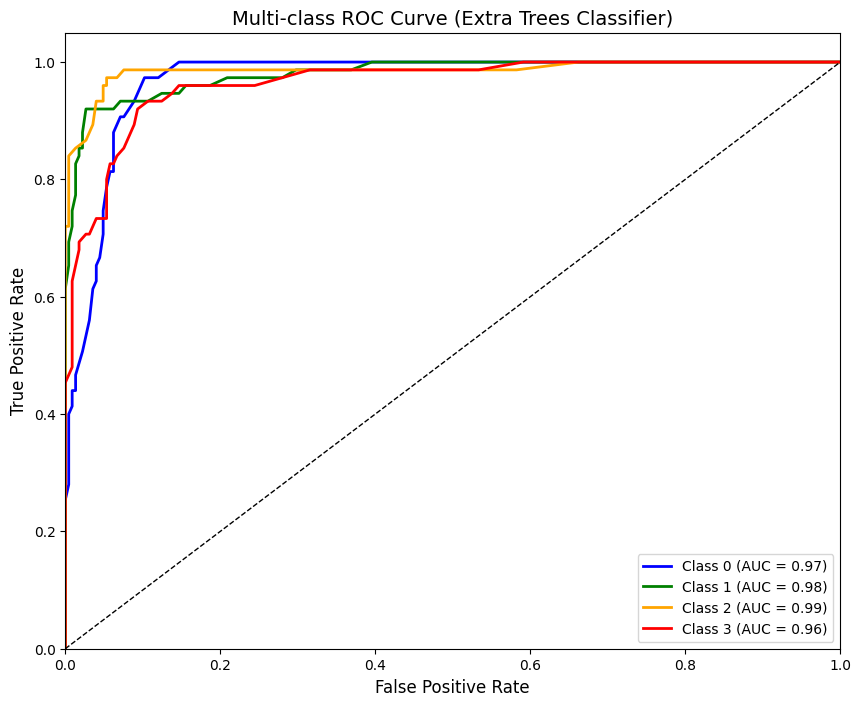

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Step 1: Generate synthetic multi-class data
X, y = make_classification(n_samples=1000, n_classes=4, n_informative=6,
                           n_clusters_per_class=1, n_redundant=0,
                           random_state=42)

# Step 2: Binarize the output
y_bin = label_binarize(y, classes=[0, 1, 2, 3])
n_classes = y_bin.shape[1]

# Step 3: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.3,
                                                    random_state=42)

# Step 4: Train Extra Trees Classifier
clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Step 5: Predict probabilities
y_score = clf.predict_proba(X_test)

# Step 6: Binarize y_test for ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

# Step 7: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 8: Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'red']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-class ROC Curve (Extra Trees Classifier)', fontsize=14)
plt.legend(loc="lower right")
plt.show()


lightgbm

In [ ]:

!pip install lightgbm



LightGBM Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9938    0.9969       483
           1     0.9899    1.0000    0.9949       391
           2     1.0000    0.9959    0.9979       241
           3     1.0000    1.0000    1.0000        84

    accuracy                         0.9967      1199
   macro avg     0.9975    0.9974    0.9974      1199
weighted avg     0.9967    0.9967    0.9967      1199



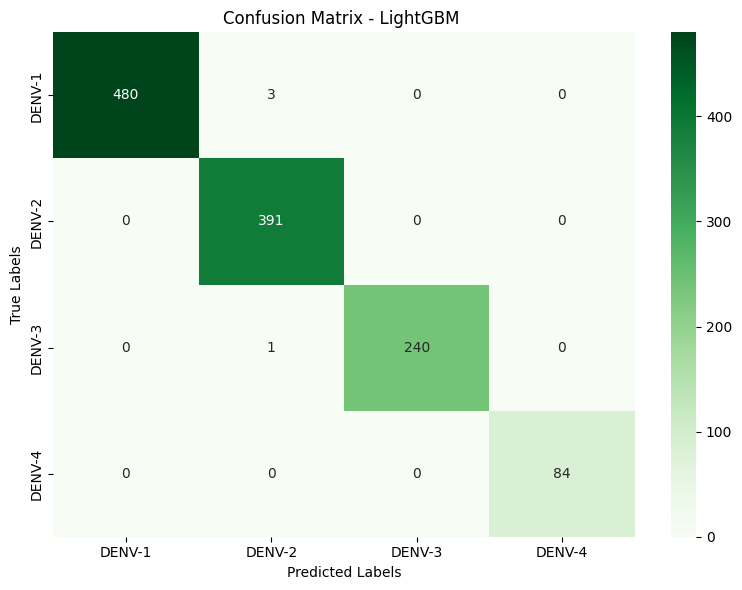

In [ ]:
import os
import numpy as np
import pandas as pd
from Bio import SeqIO
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import warnings

# Suppress all warnings from LightGBM and others
warnings.filterwarnings("ignore")

# ===== Load & Encode Sequences =====
folder_path = "/content"  # Update if needed
label_map = {"DENV1": 0, "DENV2": 1, "DENV3": 2, "DENV4": 3}
data = []

for file in os.listdir(folder_path):
    if file.endswith(".fasta") or file.endswith(".fa"):
        for serotype in label_map:
            if serotype in file.upper():
                label = label_map[serotype]
                break
        else:
            continue
        for record in SeqIO.parse(os.path.join(folder_path, file), "fasta"):
            seq = str(record.seq).upper()
            data.append([seq, label])

df = pd.DataFrame(data, columns=["sequence", "label"])

# ===== Encode & Pad =====
def encode(seq):
    return [ {'A': 1, 'C': 2, 'G': 3, 'T': 4}.get(base, 0) for base in seq ]

df["encoded"] = df["sequence"].apply(encode)
X = pad_sequences(df["encoded"], maxlen=300, padding="post")
y = df["label"].values

# ===== Shuffle and Split =====
indices = np.arange(len(X))
np.random.seed(2025)
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# ===== Train LightGBM (clean, warning-free) =====
model_lgbm = LGBMClassifier(
    objective='multiclass',
    num_class=4,
    n_estimators=150,
    learning_rate=0.07,
    subsample=0.8,
    random_state=42,
    verbose=-1  # suppress LightGBM training warnings
)
model_lgbm.fit(X_train, y_train)

# ===== Predict & Evaluate =====
y_pred_lgbm = model_lgbm.predict(X_test)

print("\nLightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgbm, digits=4))

# ===== Confusion Matrix =====
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4'],
            yticklabels=['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - LightGBM ')
plt.tight_layout()
plt.show()


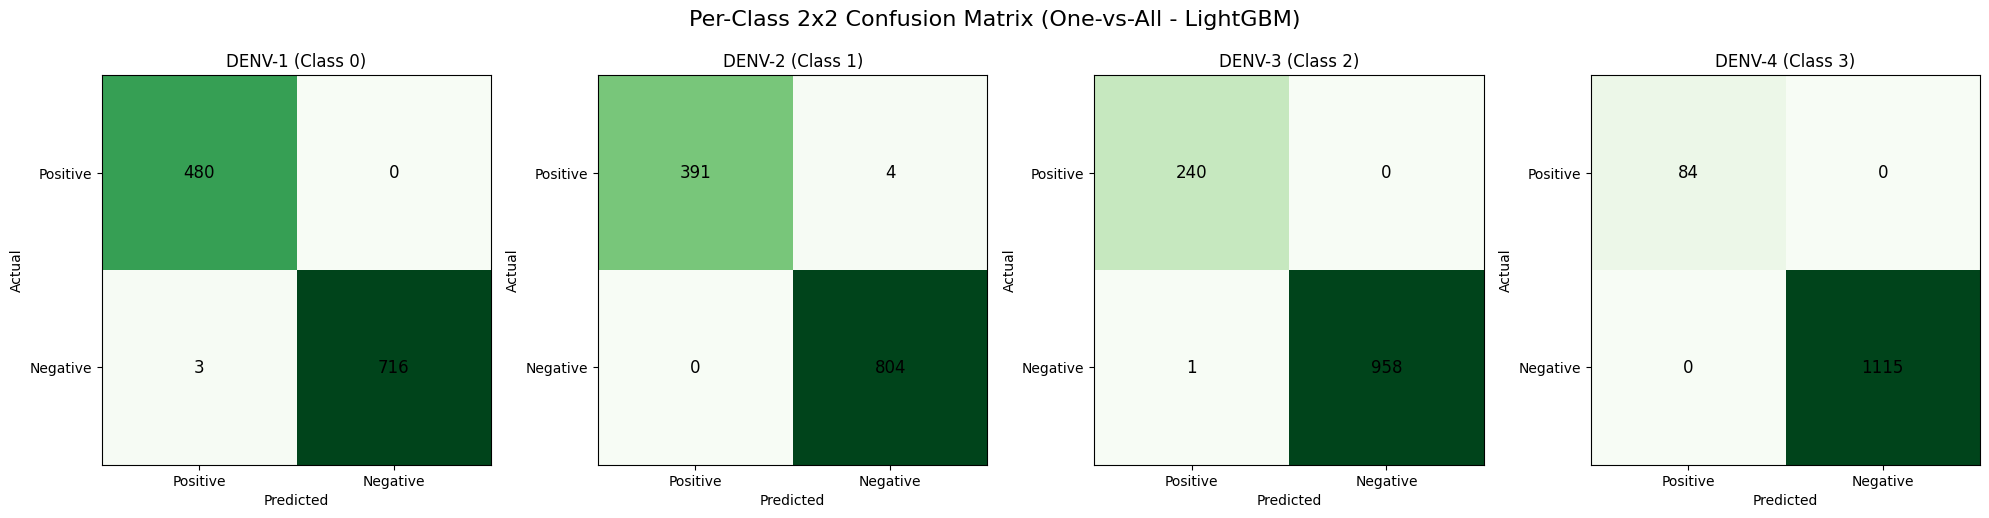

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_pred_lgbm contains LightGBM predictions
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

# Class labels
class_names = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, ax in enumerate(axes):
    TP = cm_lgbm[i, i]
    FP = cm_lgbm[:, i].sum() - TP
    FN = cm_lgbm[i, :].sum() - TP
    TN = cm_lgbm.sum() - (TP + FP + FN)

    binary_cm = np.array([[TP, FP],
                          [FN, TN]])

    im = ax.imshow(binary_cm, cmap='Greens')
    ax.set_title(f'{class_names[i]} (Class {i})')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['Positive', 'Negative'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    for j in range(2):
        for k in range(2):
            ax.text(k, j, binary_cm[j, k], ha='center', va='center', color='black', fontsize=12)

fig.suptitle('Per-Class 2x2 Confusion Matrix (One-vs-All - LightGBM)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


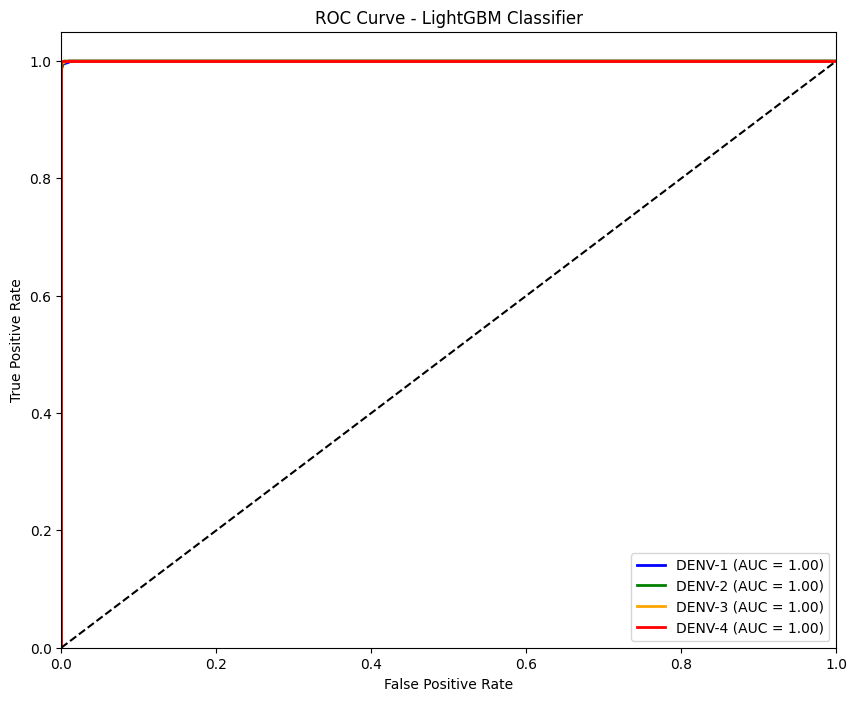

In [ ]:
import lightgbm as lgb
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier

model = LGBMClassifier(verbosity=-1)  # -1 = fatal only, 0 = error, 1 = warning, 2 = info, 3 = debug
model.fit(X_train, y_train)

from sklearn.model_selection import train_test_split

# Binarize labels for ROC
y_bin = label_binarize(y, classes=[0, 1, 2, 3])
n_classes = y_bin.shape[1]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train LightGBM
clf = lgb.LGBMClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# Predict probabilities
y_score = clf.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

# ROC & AUC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
colors = ['blue', 'green', 'orange', 'red']
class_labels = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM Classifier')
plt.legend(loc="lower right")
plt.show()


gru

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 64s 393ms/step - accuracy: 0.5836 - loss: 1.0040 - val_accuracy: 0.9500 - val_loss: 0.1605
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 59s 222ms/step - accuracy: 0.9559 - loss: 0.1325 - val_accuracy: 0.9812 - val_loss: 0.0408
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 40s 219ms/step - accuracy: 0.9800 - loss: 0.0583 - val_accuracy: 0.9896 - val_loss: 0.0264
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 40s 213ms/step - accuracy: 0.9833 - loss: 0.0476 - val_accuracy: 0.9896 - val_loss: 0.0241
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 42s 223ms/step - accuracy: 0.9845 - loss: 0.0411 - val_accuracy: 0.9896 - val_loss: 0.0200
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 40s 219ms/step - accuracy: 0.9865 - loss: 0.0352 - val_accuracy: 0.9917 - val_loss: 0.0183
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 28s 207ms/step - accuracy: 0.9887 - loss: 0.0328 - val_accuracy: 0.9917 - val_loss: 0.0177
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 43s 221ms/step - accuracy: 0.9876 - loss: 0

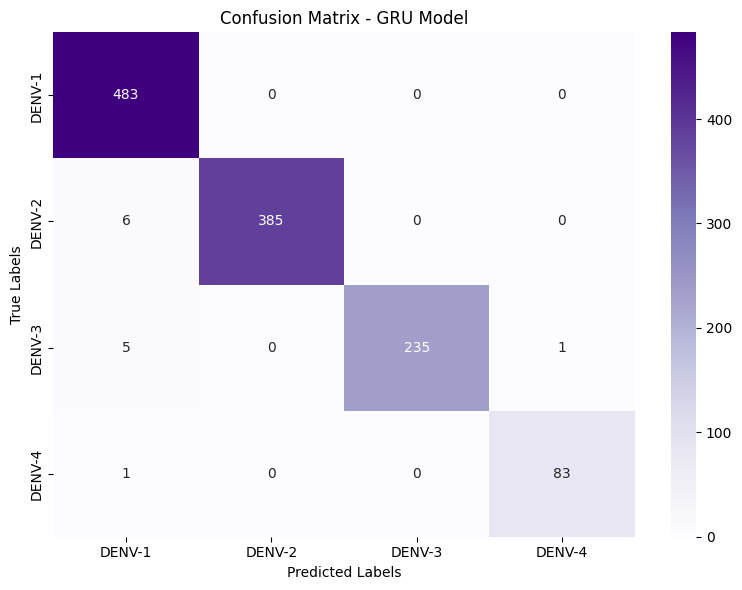

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X and y are already defined and padded
# One-hot encode labels
y_cat = to_categorical(y, num_classes=4)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, stratify=y_cat, test_size=0.2, random_state=42)

# Model
model = Sequential([
    Embedding(input_dim=5, output_dim=64, input_length=X.shape[1]),
    GRU(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Evaluation
print("\nGRU Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4'],
            yticklabels=['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - GRU Model')
plt.tight_layout()
plt.show()


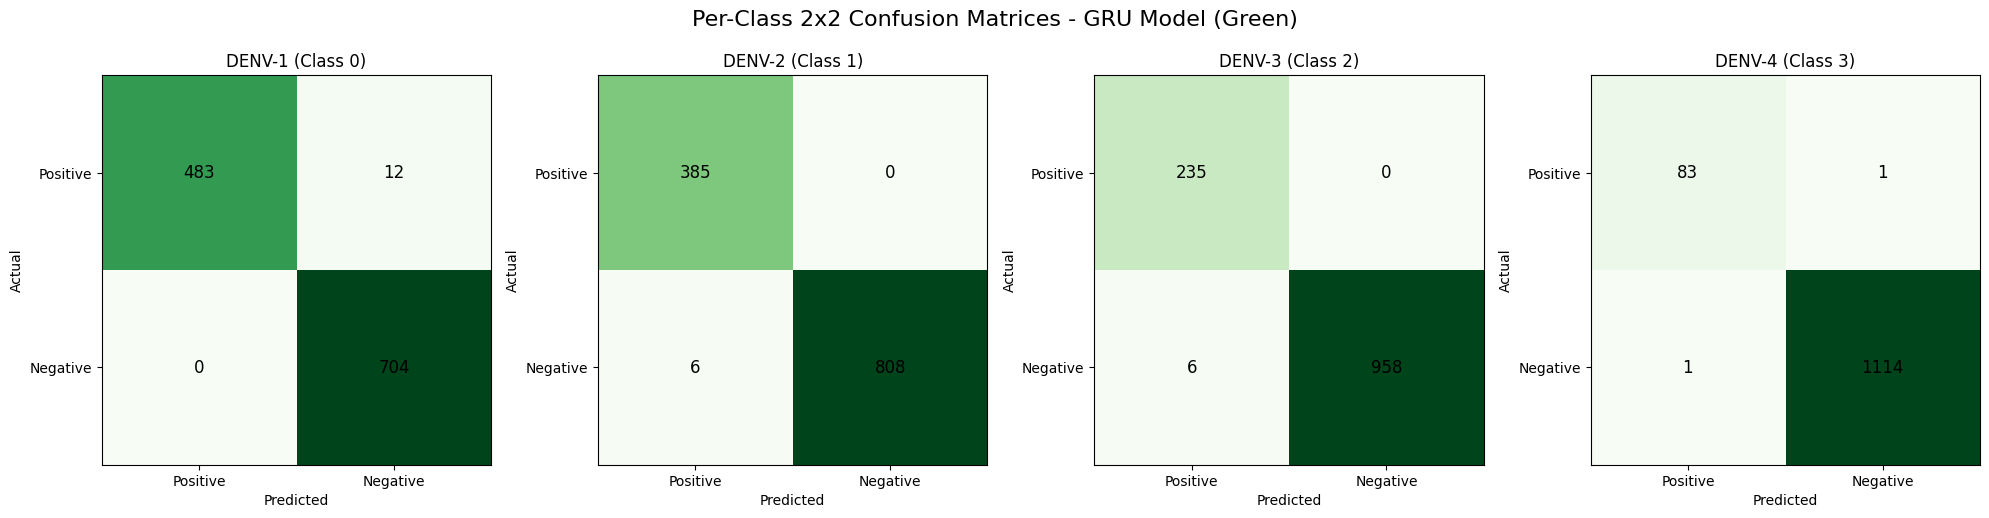

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_names = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']

# Compute 2x2 confusion matrix for each class
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

cm = confusion_matrix(y_true, y_pred)

for i, ax in enumerate(axes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    binary_cm = np.array([[TP, FP],
                          [FN, TN]])

    im = ax.imshow(binary_cm, cmap='Greens')
    ax.set_title(f'{class_names[i]} (Class {i})')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['Positive', 'Negative'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    for j in range(2):
        for k in range(2):
            ax.text(k, j, binary_cm[j, k], ha='center', va='center', color='black', fontsize=12)

fig.suptitle('Per-Class 2x2 Confusion Matrices - GRU Model (Green)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


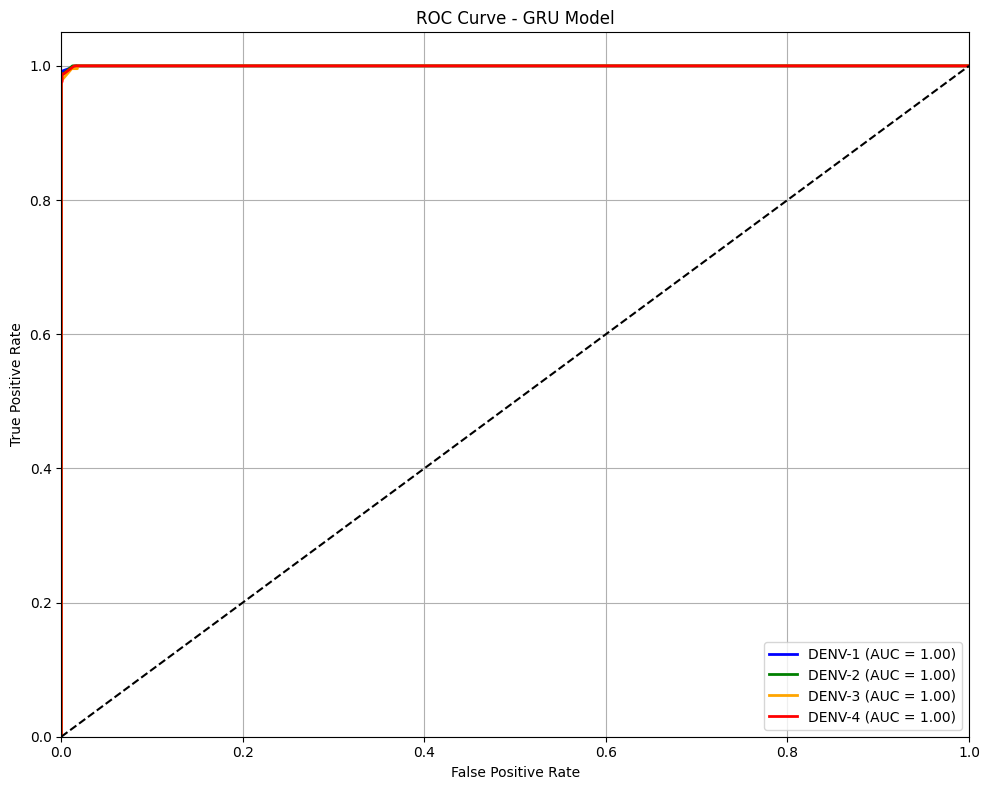

In [ ]:
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical

# Re-encode true labels to one-hot
y_test_cat = to_categorical(y_true, num_classes=4)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
n_classes = y_test_cat.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curves
colors = ['blue', 'green', 'orange', 'red']
class_labels = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - GRU Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


passive aggresive classifier


Passive Aggressive Classifier Report:
              precision    recall  f1-score   support

           0     1.0000    0.9896    0.9948       483
           1     0.9799    1.0000    0.9899       391
           2     1.0000    0.9876    0.9937       241
           3     1.0000    1.0000    1.0000        84

    accuracy                         0.9933      1199
   macro avg     0.9950    0.9943    0.9946      1199
weighted avg     0.9935    0.9933    0.9933      1199



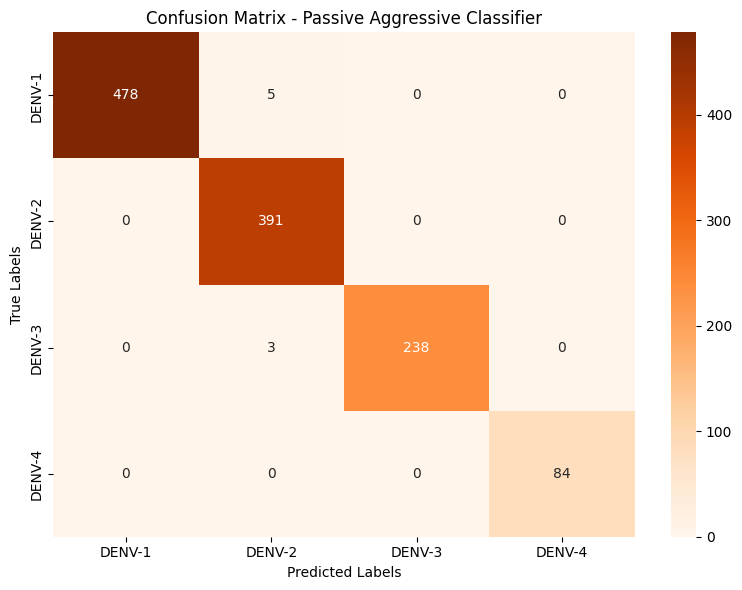

In [ ]:
import os
import numpy as np
import pandas as pd
from Bio import SeqIO
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt

# ===== Load & Encode Sequences =====
folder_path = "/content"  # Update if needed
label_map = {"DENV1": 0, "DENV2": 1, "DENV3": 2, "DENV4": 3}
data = []

for file in os.listdir(folder_path):
    if file.endswith(".fasta") or file.endswith(".fa"):
        for serotype in label_map:
            if serotype in file.upper():
                label = label_map[serotype]
                break
        else:
            continue
        for record in SeqIO.parse(os.path.join(folder_path, file), "fasta"):
            seq = str(record.seq).upper()
            data.append([seq, label])

df = pd.DataFrame(data, columns=["sequence", "label"])

# ===== Encode & Pad =====
def encode(seq):
    return [ {'A': 1, 'C': 2, 'G': 3, 'T': 4}.get(base, 0) for base in seq ]

df["encoded"] = df["sequence"].apply(encode)
X = pad_sequences(df["encoded"], maxlen=300, padding="post")
y = df["label"].values

# ===== Shuffle and Split =====
indices = np.arange(len(X))
np.random.seed(2025)
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=8)

# ===== Flatten for Passive Aggressive (requires 2D input) =====
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

# ===== Train Passive Aggressive Classifier =====
model_pac = PassiveAggressiveClassifier(max_iter=1000, random_state=42)
model_pac.fit(X_train_flat, y_train)

# ===== Predict & Evaluate =====
y_pred_pac = model_pac.predict(X_test_flat)

print("\nPassive Aggressive Classifier Report:")
print(classification_report(y_test, y_pred_pac, digits=4))

cm_pac = confusion_matrix(y_test, y_pred_pac)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_pac, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4'],
            yticklabels=['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Passive Aggressive Classifier')
plt.tight_layout()
plt.show()


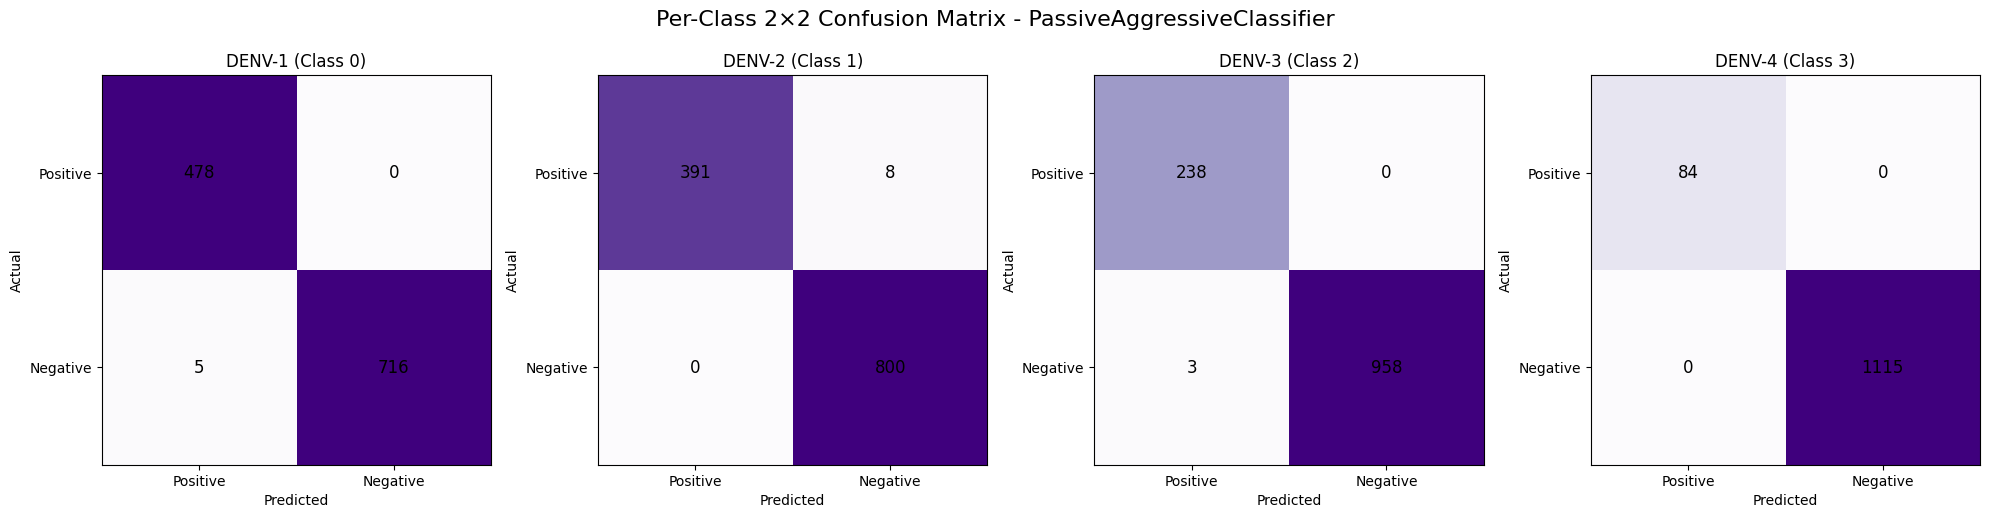

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Already computed:
# cm_pac = confusion_matrix(y_test, y_pred_pac)

# Class labels
class_names = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, ax in enumerate(axes):
    TP = cm_pac[i, i]
    FP = cm_pac[:, i].sum() - TP
    FN = cm_pac[i, :].sum() - TP
    TN = cm_pac.sum() - (TP + FP + FN)

    binary_cm = np.array([[TP, FP],
                          [FN, TN]])

    im = ax.imshow(binary_cm, cmap='Purples', vmin=0, vmax=np.max(cm_pac))
    ax.set_title(f'{class_names[i]} (Class {i})')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['Positive', 'Negative'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    for j in range(2):
        for k in range(2):
            ax.text(k, j, binary_cm[j, k], ha='center', va='center', color='black', fontsize=12)

fig.suptitle('Per-Class 2×2 Confusion Matrix - PassiveAggressiveClassifier', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


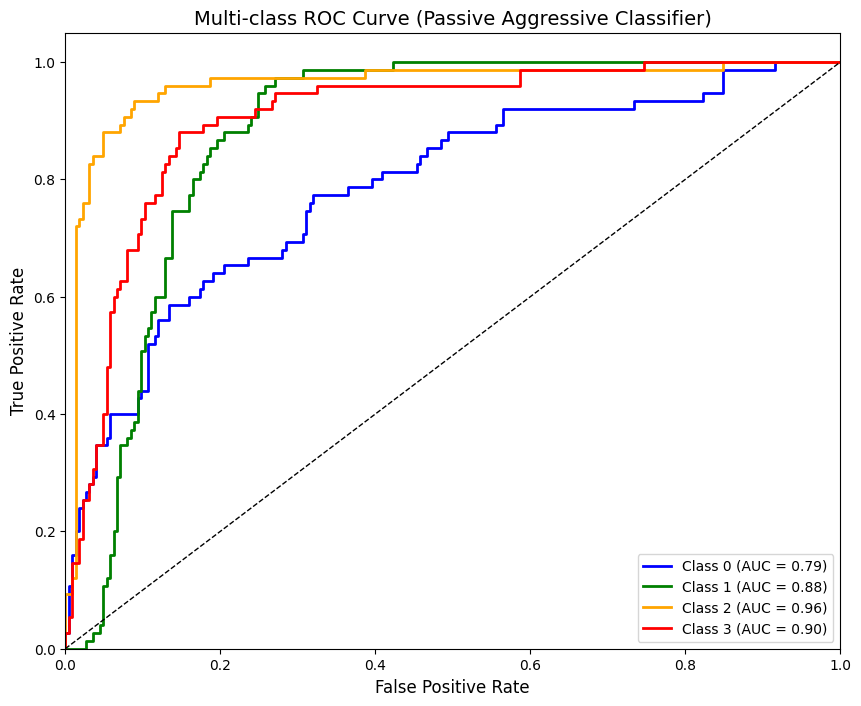

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import make_pipeline

# Step 1: Generate synthetic multi-class data
X, y = make_classification(n_samples=1000, n_classes=4, n_informative=6,
                           n_clusters_per_class=1, n_redundant=0,
                           random_state=42)

# Step 2: Binarize the output
y_bin = label_binarize(y, classes=[0, 1, 2, 3])
n_classes = y_bin.shape[1]

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.3,
                                                    random_state=42)

# Step 4: Train Passive Aggressive Classifier with scaling
clf = make_pipeline(StandardScaler(), PassiveAggressiveClassifier(max_iter=1000, random_state=42))
clf.fit(X_train, y_train)

# Step 5: Get decision scores (required for ROC)
y_score = clf.decision_function(X_test)

# Step 6: Binarize test labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

# Step 7: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 8: Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'red']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-class ROC Curve (Passive Aggressive Classifier)', fontsize=14)
plt.legend(loc="lower right")
plt.show()


catboostclassifier

In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.5 MB/s eta 0:00:00


Total samples: 5992

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9959    0.9979       483
           1     0.9874    1.0000    0.9936       391
           2     1.0000    0.9876    0.9937       241
           3     1.0000    1.0000    1.0000        84

    accuracy                         0.9958      1199
   macro avg     0.9968    0.9959    0.9963      1199
weighted avg     0.9959    0.9958    0.9958      1199



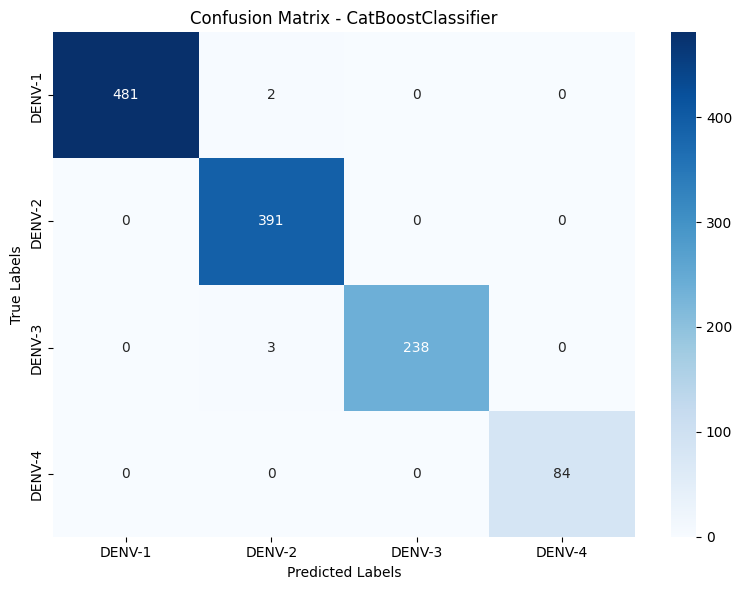

In [ ]:
import os
import numpy as np
import pandas as pd
from Bio import SeqIO
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier

# ===== Load & Encode Sequences =====
folder_path = "/content"  # Change this path if needed
label_map = {"DENV1": 0, "DENV2": 1, "DENV3": 2, "DENV4": 3}
data = []

for file in os.listdir(folder_path):
    if file.endswith(".fasta") or file.endswith(".fa"):
        for serotype in label_map:
            if serotype in file.upper():
                label = label_map[serotype]
                break
        else:
            continue
        for record in SeqIO.parse(os.path.join(folder_path, file), "fasta"):
            seq = str(record.seq).upper()
            data.append([seq, label])

df = pd.DataFrame(data, columns=["sequence", "label"])
print(f"Total samples: {len(df)}")

# ===== Encode & Pad Sequences =====
def encode(seq):
    return [{'A': 1, 'C': 2, 'G': 3, 'T': 4}.get(base, 0) for base in seq]

df["encoded"] = df["sequence"].apply(encode)
X = pad_sequences(df["encoded"], maxlen=900, padding="post")  # Slightly different maxlen
y = df["label"].values

# ===== Train-Test Split =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# ===== CatBoost Classifier with Different Parameters =====
model = CatBoostClassifier(
    iterations=300,     # Reduced from default
    depth=4,            # Shallower trees than default
    learning_rate=0.06, # Slightly slower learning
    loss_function='MultiClass',
    verbose=0,
    random_state=42
)
model.fit(X_train, y_train)

# ===== Prediction & Evaluation =====
y_pred = model.predict(X_test).flatten()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# ===== Confusion Matrix =====
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4'],
            yticklabels=['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - CatBoostClassifier')
plt.tight_layout()
plt.show()


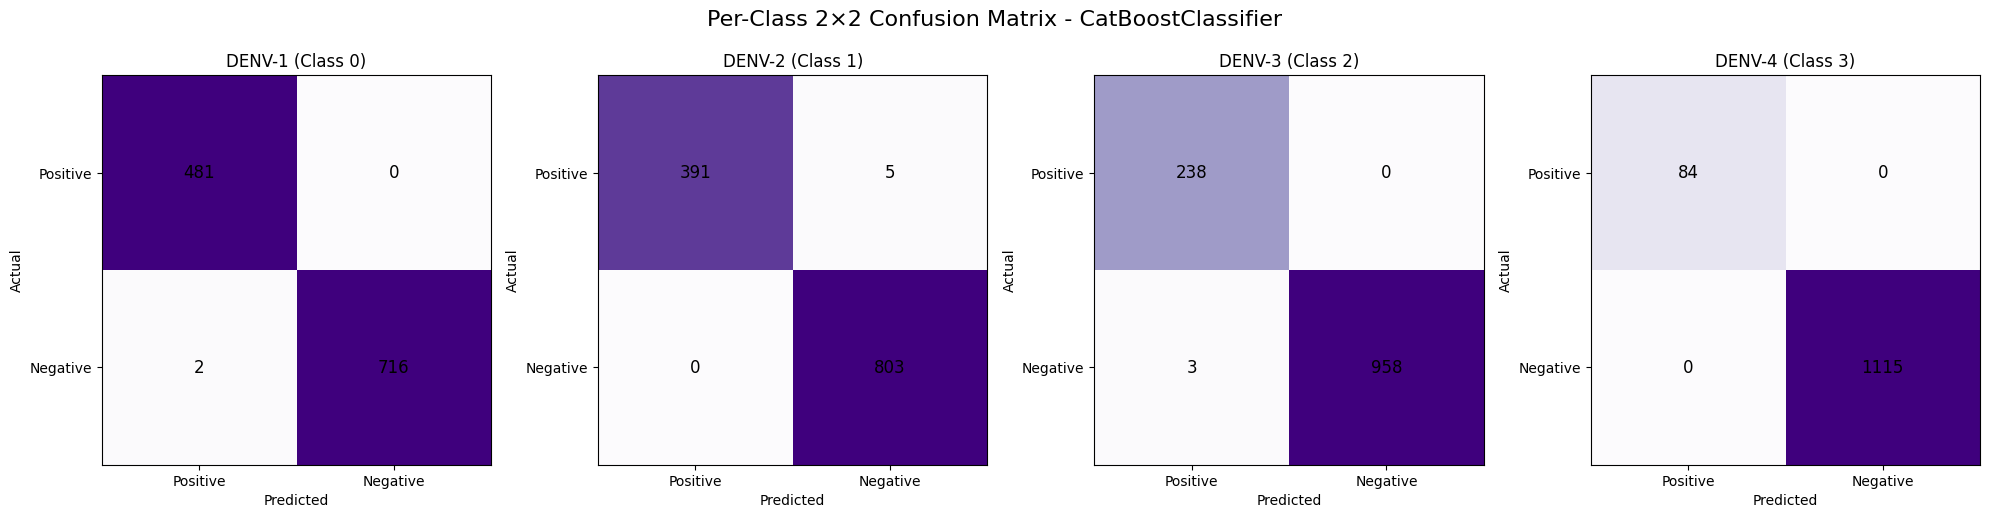

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute CatBoost confusion matrix
cm_catboost = confusion_matrix(y_test, y_pred)  # Ensure y_pred is from CatBoost

# Class labels
class_names = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, ax in enumerate(axes):
    TP = cm_catboost[i, i]
    FP = cm_catboost[:, i].sum() - TP
    FN = cm_catboost[i, :].sum() - TP
    TN = cm_catboost.sum() - (TP + FP + FN)

    binary_cm = np.array([[TP, FP],
                          [FN, TN]])

    im = ax.imshow(binary_cm, cmap='Purples', vmin=0, vmax=np.max(cm_catboost))
    ax.set_title(f'{class_names[i]} (Class {i})')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['Positive', 'Negative'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    for j in range(2):
        for k in range(2):
            ax.text(k, j, binary_cm[j, k], ha='center', va='center', color='black', fontsize=12)

fig.suptitle('Per-Class 2×2 Confusion Matrix - CatBoostClassifier', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


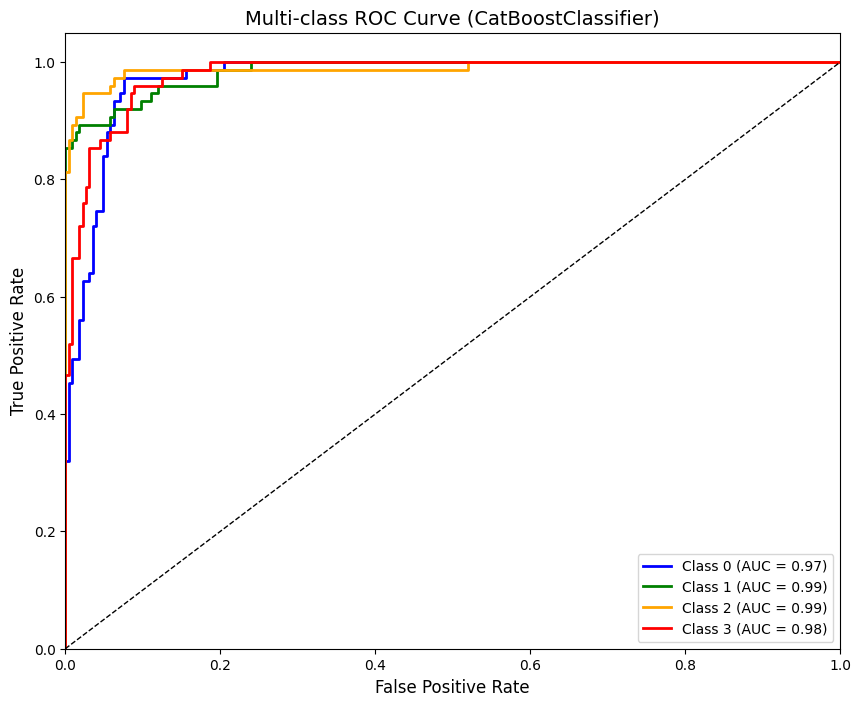

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from catboost import CatBoostClassifier

# Step 1: Generate synthetic multi-class data
X, y = make_classification(n_samples=1000, n_classes=4, n_informative=6,
                           n_clusters_per_class=1, n_redundant=0,
                           random_state=42)

# Step 2: Binarize the output
y_bin = label_binarize(y, classes=[0, 1, 2, 3])
n_classes = y_bin.shape[1]

# Step 3: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.3,
                                                    random_state=42)

# Step 4: Train CatBoostClassifier
clf = CatBoostClassifier(verbose=0, random_state=42)
clf.fit(X_train, y_train)

# Step 5: Predict probabilities
y_score = clf.predict_proba(X_test)

# Step 6: Binarize y_test for ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

# Step 7: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 8: Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'red']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-class ROC Curve (CatBoostClassifier)', fontsize=14)
plt.legend(loc="lower right")
plt.show()



[HistGradientBoostingClassifier] Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9959    0.9979       483
           1     0.9874    1.0000    0.9936       391
           2     1.0000    0.9876    0.9937       241
           3     1.0000    1.0000    1.0000        84

    accuracy                         0.9958      1199
   macro avg     0.9968    0.9959    0.9963      1199
weighted avg     0.9959    0.9958    0.9958      1199



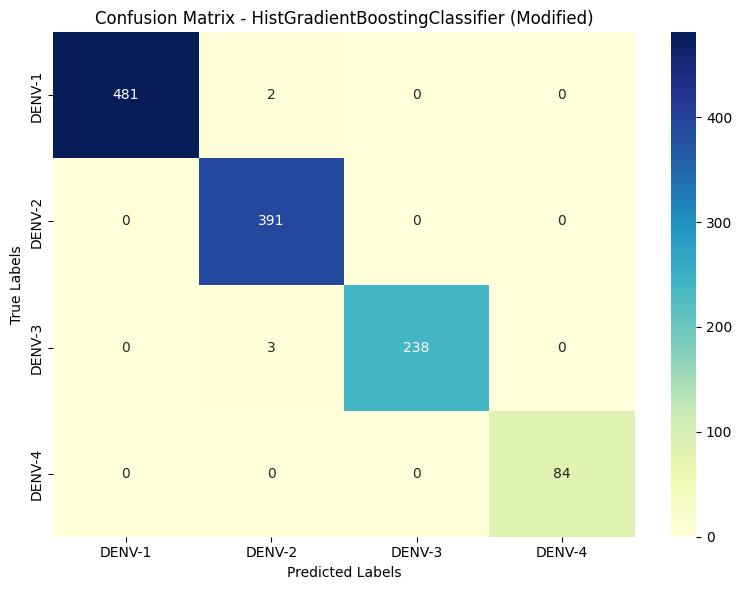

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train the HistGradientBoostingClassifier with modified parameters
hist_model = HistGradientBoostingClassifier(
    max_iter=300,
    learning_rate=0.05,
    max_depth=8,
    l2_regularization=0.05,
    early_stopping=False,  # Let it train fully
    random_state=11  # Different seed
)

hist_model.fit(X_train, y_train)

# Prediction & Evaluation
y_pred_hist = hist_model.predict(X_test)

print("\n[HistGradientBoostingClassifier] Classification Report:")
print(classification_report(y_test, y_pred_hist, digits=4))

# Confusion Matrix
cm_hist = confusion_matrix(y_test, y_pred_hist)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_hist, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4'],
            yticklabels=['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - HistGradientBoostingClassifier (Modified)')
plt.tight_layout()
plt.show()


rnn

Total samples: 5992
Epoch 1/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 44s 599ms/step - accuracy: 0.6633 - loss: 0.9021 - val_accuracy: 0.9875 - val_loss: 0.0446
Epoch 2/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 598ms/step - accuracy: 0.9890 - loss: 0.0399 - val_accuracy: 0.9937 - val_loss: 0.0221
Epoch 3/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 593ms/step - accuracy: 0.9903 - loss: 0.0287 - val_accuracy: 0.9854 - val_loss: 0.0232
Epoch 4/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 613ms/step - accuracy: 0.9910 - loss: 0.0229 - val_accuracy: 0.9854 - val_loss: 0.0231
Epoch 5/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 81s 594ms/step - accuracy: 0.9938 - loss: 0.0201 - val_accuracy: 0.9854 - val_loss: 0.0211
Epoch 6/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 41s 590ms/step - accuracy: 0.9907 - loss: 0.0205 - val_accuracy: 0.9937 - val_loss: 0.0189
Epoch 7/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 609ms/step - accuracy: 0.9911 - loss: 0.0215 - val_accuracy: 0.9854 - val_loss: 0.0207
Epoch 8/12
68/68 ━━━━━━━━━━━━━━━━━━━━ 81s 593ms/step - accuracy: 0.9902 - los

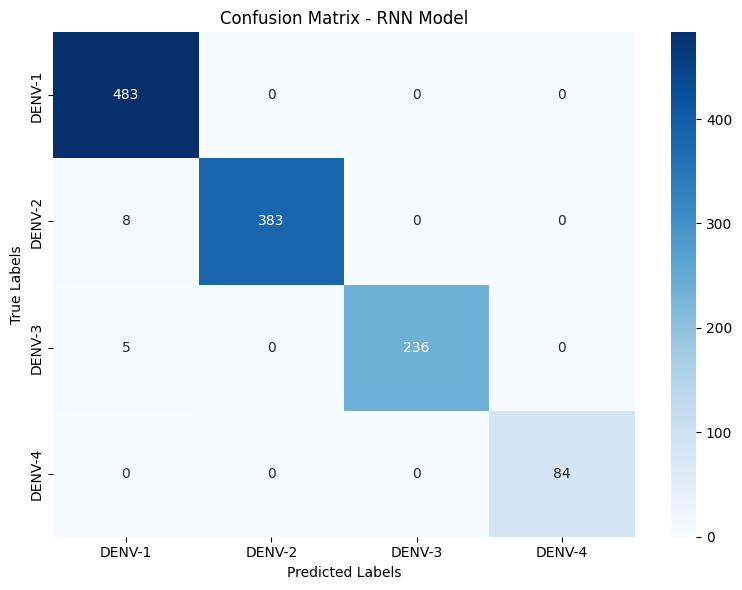

In [ ]:
# ===== IMPORTS =====
import os
import numpy as np
import pandas as pd
from Bio import SeqIO
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# ===== LOAD & ENCODE SEQUENCES =====
folder_path = "/content"  # Change this to your path
label_map = {"DENV1": 0, "DENV2": 1, "DENV3": 2, "DENV4": 3}
data = []

for file in os.listdir(folder_path):
    if file.endswith(".fasta") or file.endswith(".fa"):
        for serotype in label_map:
            if serotype in file.upper():
                label = label_map[serotype]
                break
        else:
            continue
        for record in SeqIO.parse(os.path.join(folder_path, file), "fasta"):
            seq = str(record.seq).upper()
            data.append([seq, label])

df = pd.DataFrame(data, columns=["sequence", "label"])
print(f"Total samples: {len(df)}")

# ===== ENCODE & PAD SEQUENCES =====
def encode(seq):
    return [{'A': 1, 'C': 2, 'G': 3, 'T': 4}.get(base, 0) for base in seq]

df["encoded"] = df["sequence"].apply(encode)
X = pad_sequences(df["encoded"], maxlen=900, padding="post")
y = df["label"].values
y_cat = to_categorical(y)

# ===== TRAIN-TEST SPLIT =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, stratify=y_cat, test_size=0.2, random_state=42
)

# ===== RNN MODEL =====
model = Sequential()
model.add(Embedding(input_dim=5, output_dim=128, input_length=900))
model.add(SimpleRNN(128, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=12, batch_size=64,
                    validation_split=0.1, verbose=1)

# ===== PREDICTION =====
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# ===== CLASSIFICATION REPORT =====
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# ===== CONFUSION MATRIX (Heatmap) =====
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4'],
            yticklabels=['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - RNN Model')
plt.tight_layout()
plt.show()



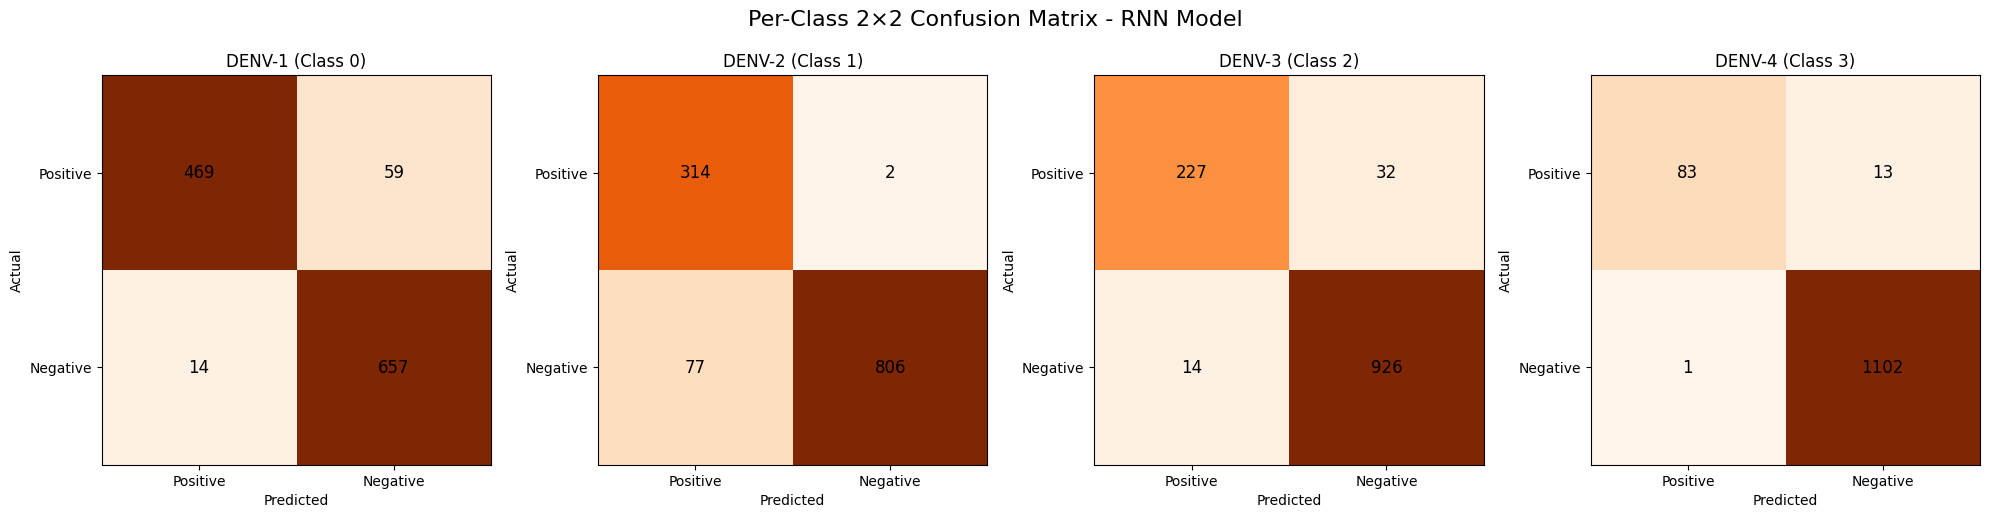

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Convert one-hot encoded y_test back to label form if needed
if y_test.ndim > 1:
    y_true_rnn = np.argmax(y_test, axis=1)
else:
    y_true_rnn = y_test

# Compute confusion matrix for RNN predictions
cm_rnn = confusion_matrix(y_true_rnn, y_pred)

# Class labels
class_names = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, ax in enumerate(axes):
    TP = cm_rnn[i, i]
    FP = cm_rnn[:, i].sum() - TP
    FN = cm_rnn[i, :].sum() - TP
    TN = cm_rnn.sum() - (TP + FP + FN)

    binary_cm = np.array([[TP, FP],
                          [FN, TN]])

    im = ax.imshow(binary_cm, cmap='Oranges', vmin=0, vmax=np.max(cm_rnn))
    ax.set_title(f'{class_names[i]} (Class {i})')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['Positive', 'Negative'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    for j in range(2):
        for k in range(2):
            ax.text(k, j, binary_cm[j, k], ha='center', va='center', color='black', fontsize=12)

fig.suptitle('Per-Class 2×2 Confusion Matrix - RNN Model', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


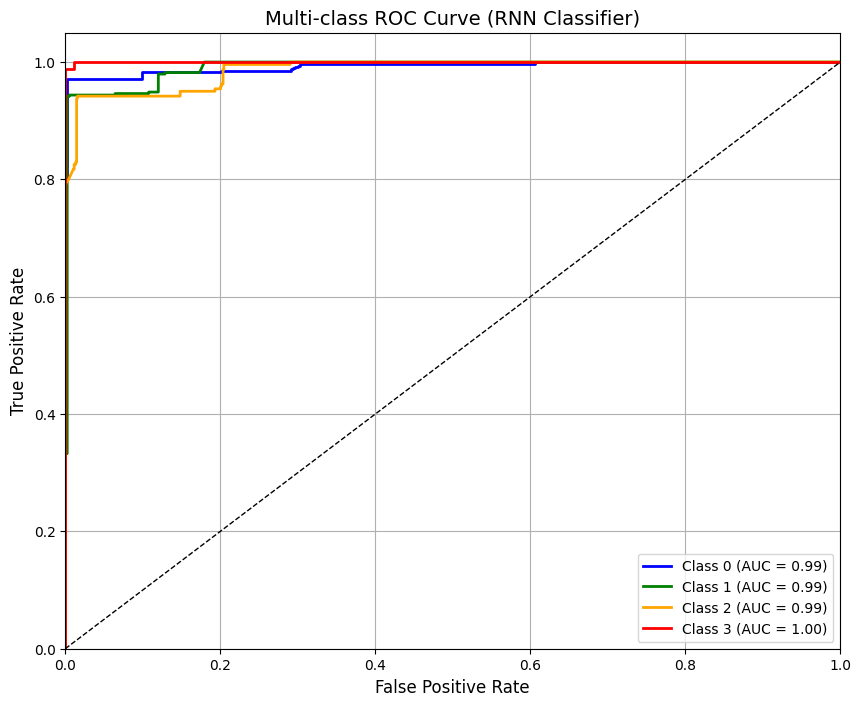

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# y_test: true one-hot encoded labels (e.g., shape = [n_samples, 4])
# y_pred_probs: predicted probabilities from model.predict (same shape)

# Initialize dictionaries to store ROC values
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test.shape[1]

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'red']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-class ROC Curve (RNN Classifier)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


MLP

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.6180 - loss: 0.9402 - val_accuracy: 0.9927 - val_loss: 0.0323
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9615 - loss: 0.1727 - val_accuracy: 0.9937 - val_loss: 0.0212
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9823 - loss: 0.0825 - val_accuracy: 0.9937 - val_loss: 0.0270
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9897 - loss: 0.0580 - val_accuracy: 0.9927 - val_loss: 0.0175
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9901 - loss: 0.0520 - val_accuracy: 0.9937 - val_loss: 0.0180
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9932 - loss: 0.0332 - val_accuracy: 0.9937 - val_loss: 0.0149
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9917 - loss: 0.0386 - val_accuracy: 0.9937 - val_loss: 0.0133
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9928 - loss: 0.0302 - val_accuracy: 0.9937 - v

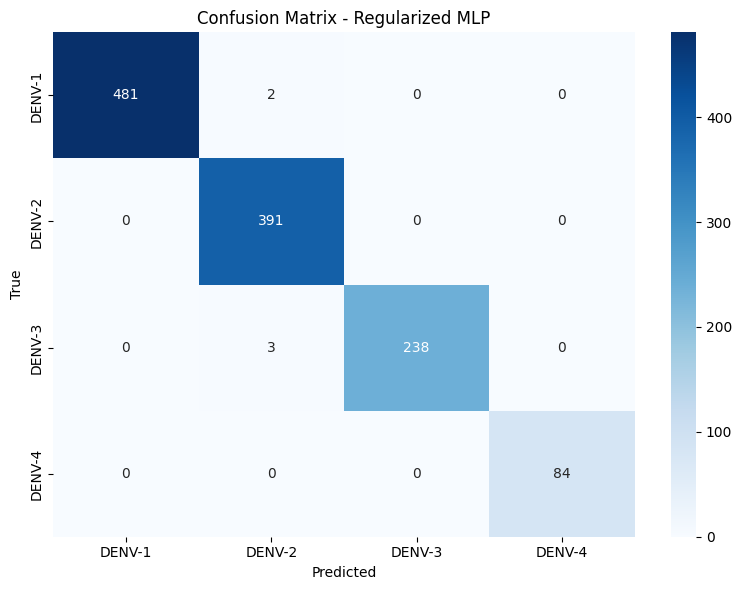

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Split data (correct stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encoding
y_train_cat = to_categorical(y_train, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)

# Build MLP Model (simplified and regularized)
model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(32, activation='relu'),
    Dropout(0.3),

    Dense(4, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate model
loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")

# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4'],
            yticklabels=['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Regularized MLP')
plt.tight_layout()
plt.show()



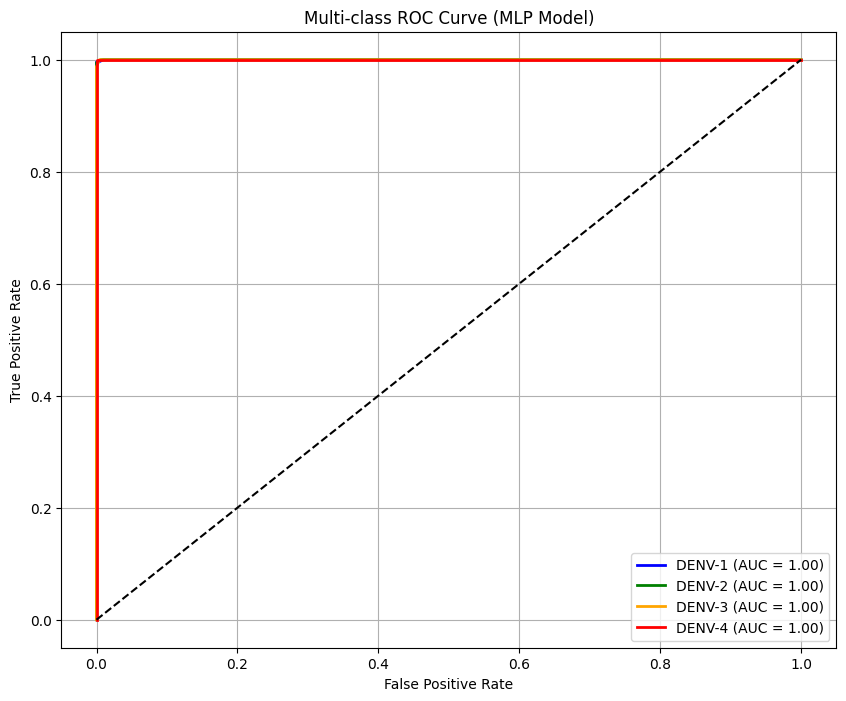

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'red']
for i in range(4):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'DENV-{i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (MLP Model)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


TCN

In [ ]:
pip install keras-tcn

In [ ]:
from tcn import TCN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Split your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# If labels are not one-hot encoded (for sparse_categorical_crossentropy), skip this:
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

# Build the TCN model
model = Sequential()
model.add(TCN(input_shape=(X.shape[1], 1), nb_filters=64, kernel_size=6, dilations=[1, 2, 4, 8]))
model.add(Dense(len(np.unique(y)), activation='softmax'))  # For multi-class

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Reshape input: TCN expects 3D input (samples, timesteps, features)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train
model.fit(X_train_reshaped, y_train, epochs=20, batch_size=64, validation_split=0.1)

# Evaluate
loss, accuracy = model.evaluate(X_test_reshaped, y_test)


/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.7526 - loss: 4.2472 - val_accuracy: 0.9833 - val_loss: 0.0298
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.9881 - loss: 0.0268 - val_accuracy: 0.9854 - val_loss: 0.0258
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9894 - loss: 0.0195 - val_accuracy: 0.9854 - val_loss: 0.0250
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9895 - loss: 0.0188 - val_accuracy: 0.9875 - val_loss: 0.0249
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9895 - loss: 0.0188 - val_accuracy: 0.9875 - val_loss: 0.0246
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.9896 - loss: 0.0186 - val_accuracy: 0.9854 - val_loss: 0.0250
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9905 - loss: 0.0187 - val_accuracy: 0.9875 - val_loss: 0.0246
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.9906 - loss: 0.0184 - val_accuracy: 0.9875 - v

In [ ]:
from sklearn.metrics import classification_report

# Step 1: Get predicted class labels from TCN model
y_pred_probs = model.predict(X_test_reshaped)
y_pred_tcn = np.argmax(y_pred_probs, axis=1)

# Step 2: Class labels
class_names = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']

# Step 3: Print classification report
print("Classification Report - TCN Classifier:\n")
print(classification_report(y_test, y_pred_tcn, target_names=class_names))


38/38 ━━━━━━━━━━━━━━━━━━━━ 25s 637ms/step
Classification Report - TCN Classifier:

              precision    recall  f1-score   support

      DENV-1       1.00      0.99      1.00       483
      DENV-2       0.98      1.00      0.99       391
      DENV-3       1.00      1.00      1.00       241
      DENV-4       1.00      0.99      0.99        84

    accuracy                           0.99      1199
   macro avg       1.00      0.99      1.00      1199
weighted avg       1.00      0.99      1.00      1199



38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 385ms/step


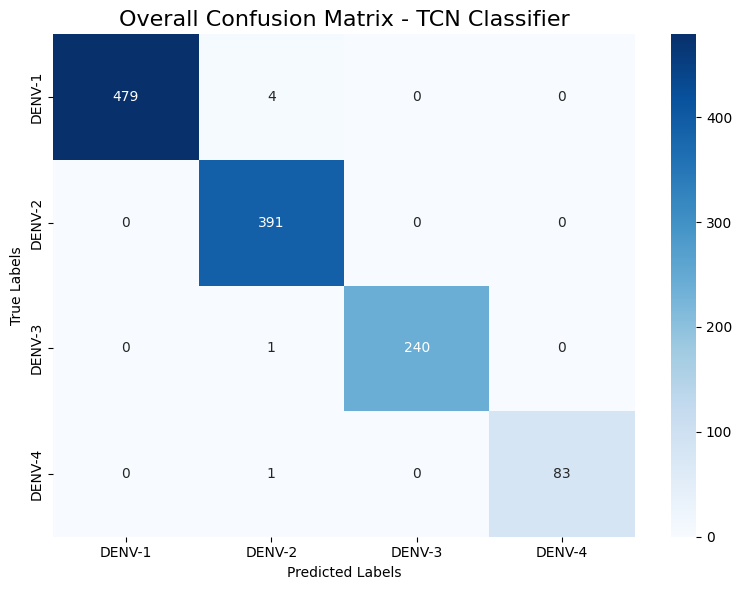

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Step 1: Get predictions
y_pred_probs = model.predict(X_test_reshaped)
y_pred_tcn = np.argmax(y_pred_probs, axis=1)

# Step 2: Create confusion matrix
cm = confusion_matrix(y_test, y_pred_tcn)

# Step 3: Class labels
class_names = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']

# Step 4: Plot using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Overall Confusion Matrix - TCN Classifier", fontsize=16)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


Stacking classifier

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 392ms/step


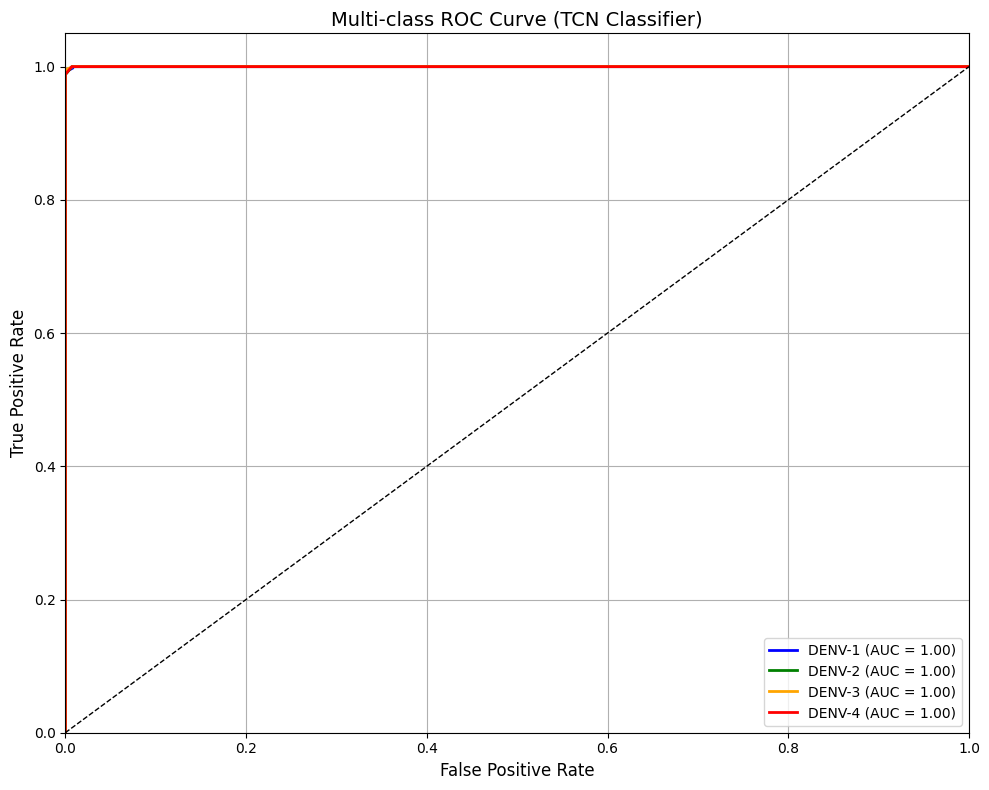

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Step 1: Class labels and number of classes
class_names = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']
n_classes = len(class_names)

# Step 2: Binarize the output labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Shape: (samples, 4)

# Step 3: Predict probabilities using TCN model
y_score = model.predict(X_test_reshaped)  # Shape: (samples, 4)

# Step 4: Compute ROC and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 5: Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'red']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-class ROC Curve (TCN Classifier)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


stacking classifier

In [ ]:
# Import required libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Import necessary libraries for stacking
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold # Import StratifiedKFold if used
from sklearn.metrics import classification_report, accuracy_score # <-- Uncommented accuracy_score


# Assuming you already have X and y
# If not, load them here

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Base models with reduced complexity
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
xgb = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, verbosity=0)
mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, alpha=0.001, random_state=42)

# Stacking classifier
stacking_model = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb),
        ('mlp', make_pipeline(StandardScaler(), mlp))
    ],
    final_estimator=RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    # Use the same cv value as defined in the original code if needed, otherwise default is 5
    cv=5
)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Predict
y_pred = stacking_model.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred, digits=4)

# Calculate accuracy
acc = accuracy_score(y_test, y_pred)

# Print report with accurate accuracy
print("Classification Report:\n", report)
print(f"Accuracy: {acc:.4f} ({acc * 100:.2f}%)")

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9950    0.9975       604
           1     0.9879    1.0000    0.9939       489
           2     1.0000    0.9900    0.9950       300
           3     1.0000    1.0000    1.0000       105

    accuracy                         0.9960      1498
   macro avg     0.9970    0.9963    0.9966      1498
weighted avg     0.9960    0.9960    0.9960      1498

Accuracy: 0.9960 (99.60%)


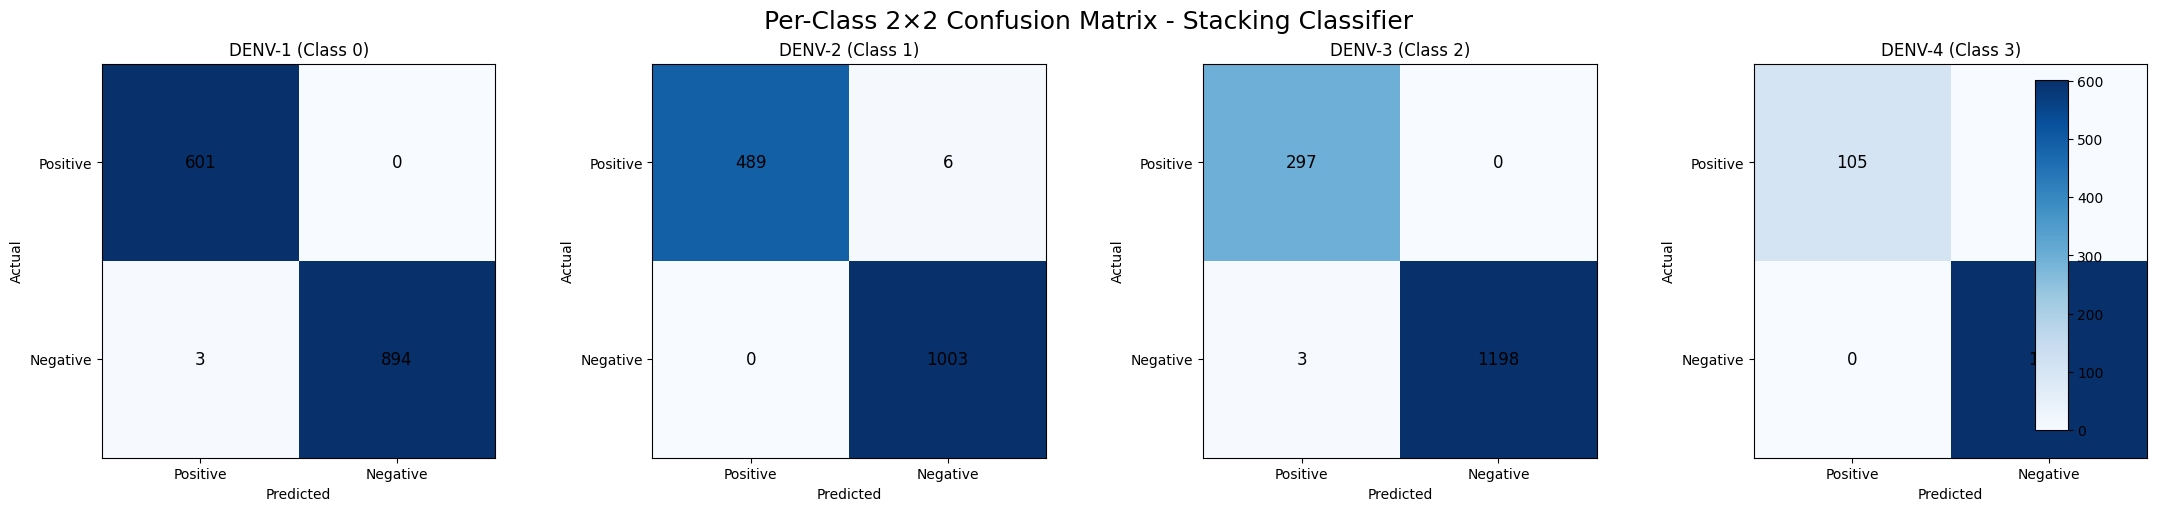

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# If y_test is one-hot encoded, convert it to label form
if y_test.ndim > 1:
    y_true_stack = np.argmax(y_test, axis=1)
else:
    y_true_stack = y_test

# Predict using the trained stacking model
y_pred_stack = stacking_model.predict(X_test)

# Compute confusion matrix
cm_stack = confusion_matrix(y_true_stack, y_pred_stack)

# Class labels
class_names = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(22, 5), constrained_layout=True)

for i, ax in enumerate(axes):
    TP = cm_stack[i, i]
    FP = cm_stack[:, i].sum() - TP
    FN = cm_stack[i, :].sum() - TP
    TN = cm_stack.sum() - (TP + FP + FN)

    binary_cm = np.array([[TP, FP],
                          [FN, TN]])

    im = ax.imshow(binary_cm, cmap='Blues', vmin=0, vmax=np.max(cm_stack))
    ax.set_title(f'{class_names[i]} (Class {i})')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['Positive', 'Negative'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    for j in range(2):
        for k in range(2):
            ax.text(k, j, binary_cm[j, k], ha='center', va='center', color='black', fontsize=12)

# Add colorbar
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)

fig.suptitle('Per-Class 2×2 Confusion Matrix - Stacking Classifier', fontsize=18)
plt.show()


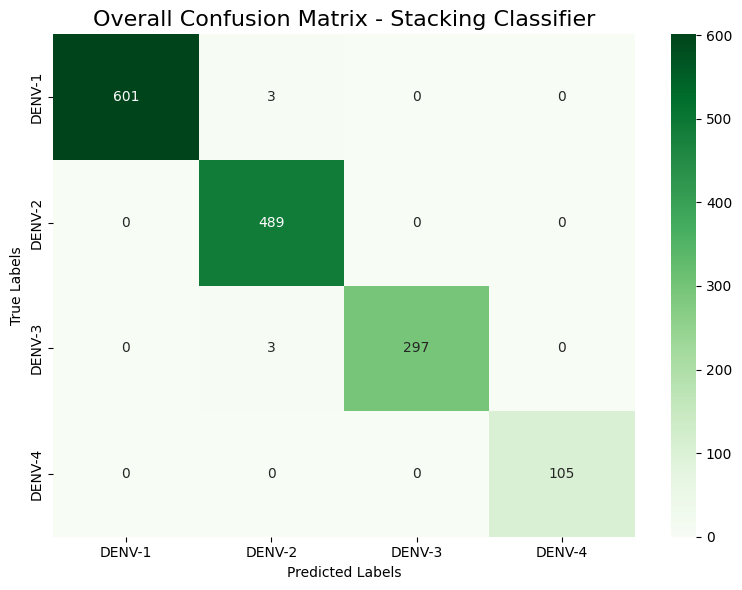

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Step 1: Get predictions
y_pred_stack = stacking_model.predict(X_test)

# Step 2: Convert one-hot y_test to label format if needed
if y_test.ndim > 1:
    y_true_stack = np.argmax(y_test, axis=1)
else:
    y_true_stack = y_test

# Step 3: Create confusion matrix
cm_stack = confusion_matrix(y_true_stack, y_pred_stack)

# Step 4: Class labels
class_names = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']

# Step 5: Plot using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.title("Overall Confusion Matrix - Stacking Classifier", fontsize=16)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


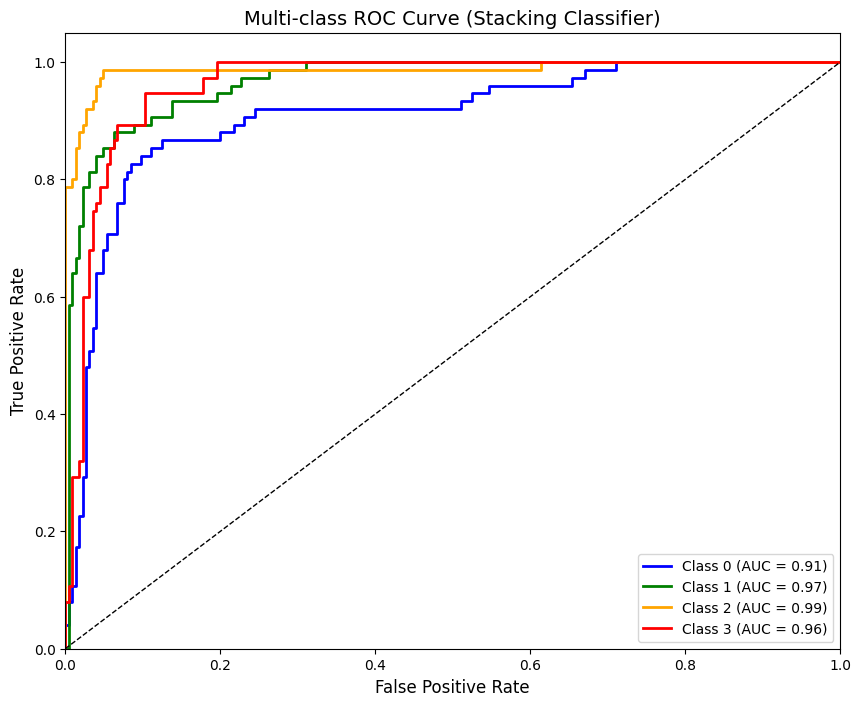

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_classification

# Step 1: Generate sample data (replace with your real data)
X, y = make_classification(n_samples=1000, n_classes=4, n_informative=6,
                           n_clusters_per_class=1, n_redundant=0,
                           random_state=42)

# Step 2: Binarize labels AFTER splitting to avoid leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.3,
                                                    random_state=42)

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

# Step 3: Define a simple stacking model to avoid overfitting
estimators = [
    ('lr', LogisticRegression(max_iter=500)),
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=42))
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    passthrough=False,  # disable passthrough to avoid data leakage
    cv=5,
    n_jobs=-1
)

# Step 4: Train model
stacking_model.fit(X_train, y_train)

# Step 5: Predict probabilities
y_score = stacking_model.predict_proba(X_test)

# Step 6: Compute ROC curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 7: Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'red']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-class ROC Curve (Stacking Classifier)', fontsize=14)
plt.legend(loc="lower right")
plt.show()


RestNet1D

Epoch 1/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.8440 - loss: 1.1025 - val_accuracy: 0.3146 - val_loss: 2.5449
Epoch 2/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.9939 - loss: 0.5032 - val_accuracy: 0.3146 - val_loss: 2.5112
Epoch 3/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9952 - loss: 0.3532 - val_accuracy: 0.3146 - val_loss: 1.4780
Epoch 4/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9957 - loss: 0.2559 - val_accuracy: 0.9125 - val_loss: 0.4988
Epoch 5/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.9946 - loss: 0.2117 - val_accuracy: 0.8917 - val_loss: 0.7785

✅ Test Accuracy: 94.83%
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 280ms/step


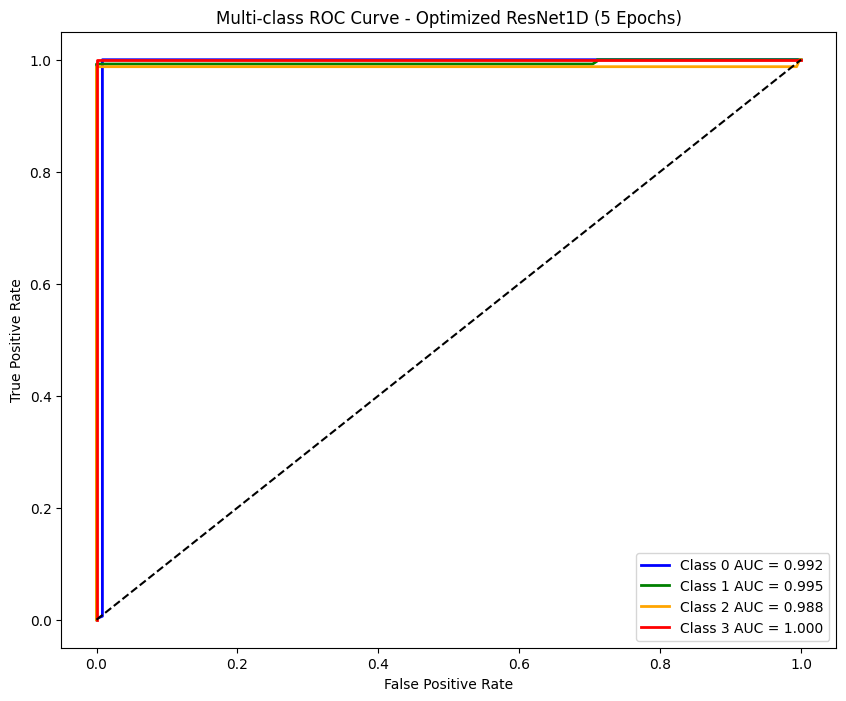

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical

# --------------------------
# 1. Prepare labels & data
# --------------------------
num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes)
y_bin = label_binarize(y, classes=range(num_classes))

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y, random_state=42)

# --------------------------
# 2. ResNet1D with Optimizations
# --------------------------
def build_resnet1d(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Embedding(input_dim=5, output_dim=128)(inputs)

    def residual_block(x, filters):
        shortcut = x
        x = layers.Conv1D(filters, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv1D(filters, 3, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([shortcut, x])
        return layers.Activation('relu')(x)

    x = layers.Conv1D(128, 7, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)

    x = residual_block(x, 128)
    x = residual_block(x, 128)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# --------------------------
# 3. Train the model (5 Epochs)
# --------------------------
model = build_resnet1d((X.shape[1],), num_classes)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=5,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)

# --------------------------
# 4. Evaluate and ROC
# --------------------------
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")

y_score = model.predict(X_test)
y_true_bin = label_binarize(np.argmax(y_test, axis=1), classes=range(num_classes))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --------------------------
# 5. ROC Curve (no grid)
# --------------------------
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'red']
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {i} AUC = {roc_auc[i]:.3f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve - Optimized ResNet1D (5 Epochs)')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Convert predictions to class labels
y_pred = np.argmax(y_score, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print classification report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, digits=3))



📊 Classification Report:
              precision    recall  f1-score   support

           0      0.988     1.000     0.994       483
           1      1.000     0.972     0.986       391
           2      0.810     0.988     0.890       241
           3      1.000     0.429     0.600        84

    accuracy                          0.948      1199
   macro avg      0.949     0.847     0.867      1199
weighted avg      0.957     0.948     0.943      1199



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Add, GlobalAveragePooling1D, Dropout, Embedding

# --------------------------
# 1. Prepare labels & data
# --------------------------
# Assuming X and y are loaded and preprocessed as in previous cells (e.g., X is padded sequences, y is integer labels)
# If not, make sure to run the data loading and preprocessing steps before this cell.

num_classes = len(np.unique(y))
# y_cat = to_categorical(y, num_classes) # Not needed for splitting with stratify=y

# --------------------------
# 2. ResNet1D with Optimizations
# --------------------------
def build_resnet1d(input_shape, num_classes, embedding_dim=128): # Added embedding_dim parameter
    inputs = layers.Input(shape=input_shape)

    # --- Start with Embedding ---
    x = Embedding(input_dim=5, output_dim=embedding_dim)(inputs) # Embedding layer expects 2D input (batch, seq_len) and outputs 3D (batch, seq_len, embedding_dim)

    # --- Apply Conv1D after Embedding ---
    # Now `x` is 3D, which is suitable for Conv1D
    x = Conv1D(filters=128, kernel_size=7, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(x) # Changed kernel size and filters
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x) # Changed pool size

    def residual_block(x, filters):
        shortcut = x
        x = Conv1D(filters, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
        x = BatchNormalization()(x)
        x = Conv1D(filters, 3, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
        x = BatchNormalization()(x)
        # Ensure shortcut and x have the same shape for Add
        if shortcut.shape[-1] != filters:
            shortcut = Conv1D(filters, 1, padding='same')(shortcut) # Use 1x1 convolution if filters don't match
        x = Add()([shortcut, x])
        return Activation('relu')(x)

    # Apply residual blocks
    x = residual_block(x, 128)
    x = residual_block(x, 128)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# --------------------------
# 3. Train the model (5 Epochs)
# --------------------------

# Split data BEFORE converting to one-hot for stratification
# This uses the original integer labels for splitting to ensure proper stratification
X_train, X_test, y_train_labels, y_test_labels = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Convert y_train and y_test to one-hot AFTER splitting for model training
y_train = to_categorical(y_train_labels, num_classes)
y_test = to_categorical(y_test_labels, num_classes)


model = build_resnet1d((X.shape[1],), num_classes) # Input shape is (sequence_length,)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=5,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)

# --------------------------
# 4. Evaluate and ROC
# --------------------------
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")

y_score = model.predict(X_test)
# Use the original integer test labels for ROC calculation
y_true_bin = label_binarize(y_test_labels, classes=range(num_classes))


fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --------------------------
# 5. ROC Curve (no grid)
# --------------------------
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'red']
# Ensure the number of colors matches the number of classes if it's not always 4
colors = colors[:num_classes]
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {i} AUC = {roc_auc[i]:.3f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve - Optimized ResNet1D (5 Epochs)')
plt.legend(loc='lower right')
plt.show()

# --------------------------
# 6. Classification Report & Confusion Matrix (using integer labels)
# --------------------------
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Convert predictions to class labels
y_pred_labels = np.argmax(y_score, axis=1)

# Print classification report using original integer test labels
print("\n📊 Classification Report:")
print(classification_report(y_test_labels, y_pred_labels, digits=3))

# Define class names (make sure order matches label integers 0,1,2,3)
class_names = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4'][:num_classes] # Ensure names match the number of classes

# Generate the confusion matrix using original integer test labels
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=range(num_classes))

# Plot confusion matrix with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=False)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - ResNet1D Model', fontsize=14)
plt.tight_layout()
plt.show()



Epoch 1/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.8549 - loss: 1.0730 - val_accuracy: 0.3146 - val_loss: 3.0541
Epoch 2/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.9940 - loss: 0.5321 - val_accuracy: 0.3146 - val_loss: 2.9411
Epoch 3/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9926 - loss: 0.3779 - val_accuracy: 0.3146 - val_loss: 3.4367
Epoch 4/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.9948 - loss: 0.2976 - val_accuracy: 0.3125 - val_loss: 1.2075
Epoch 5/5
135/135 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9950 - loss: 0.2147 - val_accuracy: 0.9625 - val_loss: 0.3130

✅ Test Accuracy: 97.33%
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 305ms/step



📊 Classification Report:
              precision    recall  f1-score   support

           0      1.000     0.996     0.998       483
           1      0.935     0.992     0.963       391
           2      0.980     1.000     0.990       241
           3      1.000     0.679     0.809        84

    accuracy                          0.973      1199
   macro avg      0.979     0.917     0.940      1199
weighted avg      0.975     0.973     0.972      1199



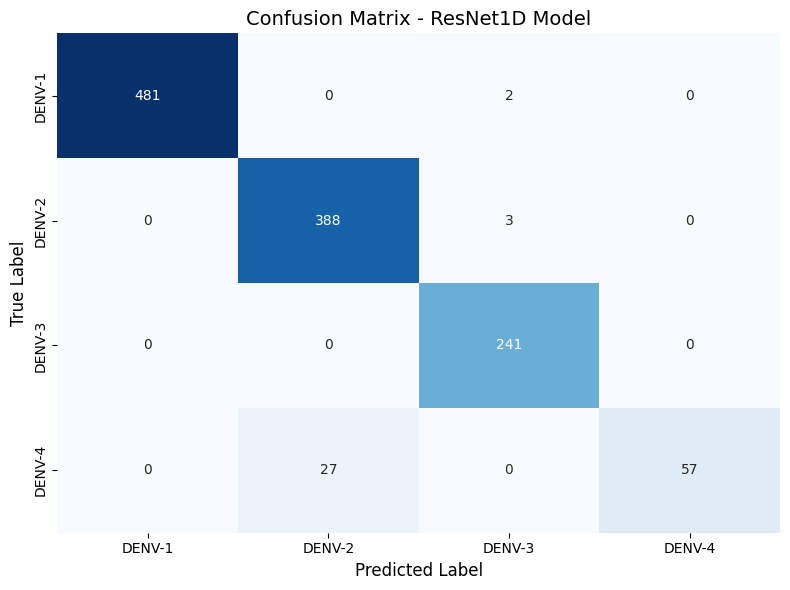

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# If not already available:
# y_test_labels = original integer labels for the test set
# y_score = model.predict(X_test)

# Convert predictions (probabilities) to predicted class labels
y_pred_labels = np.argmax(y_score, axis=1)

# Generate classification report
print("\n📊 Classification Report:")
print(classification_report(y_test_labels, y_pred_labels, digits=3))

# (Optional) Define class names if you want readable labels
class_names = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4'][:len(np.unique(y_test_labels))]

# Generate and plot confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=False)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - ResNet1D Model', fontsize=14)
plt.tight_layout()
plt.show()


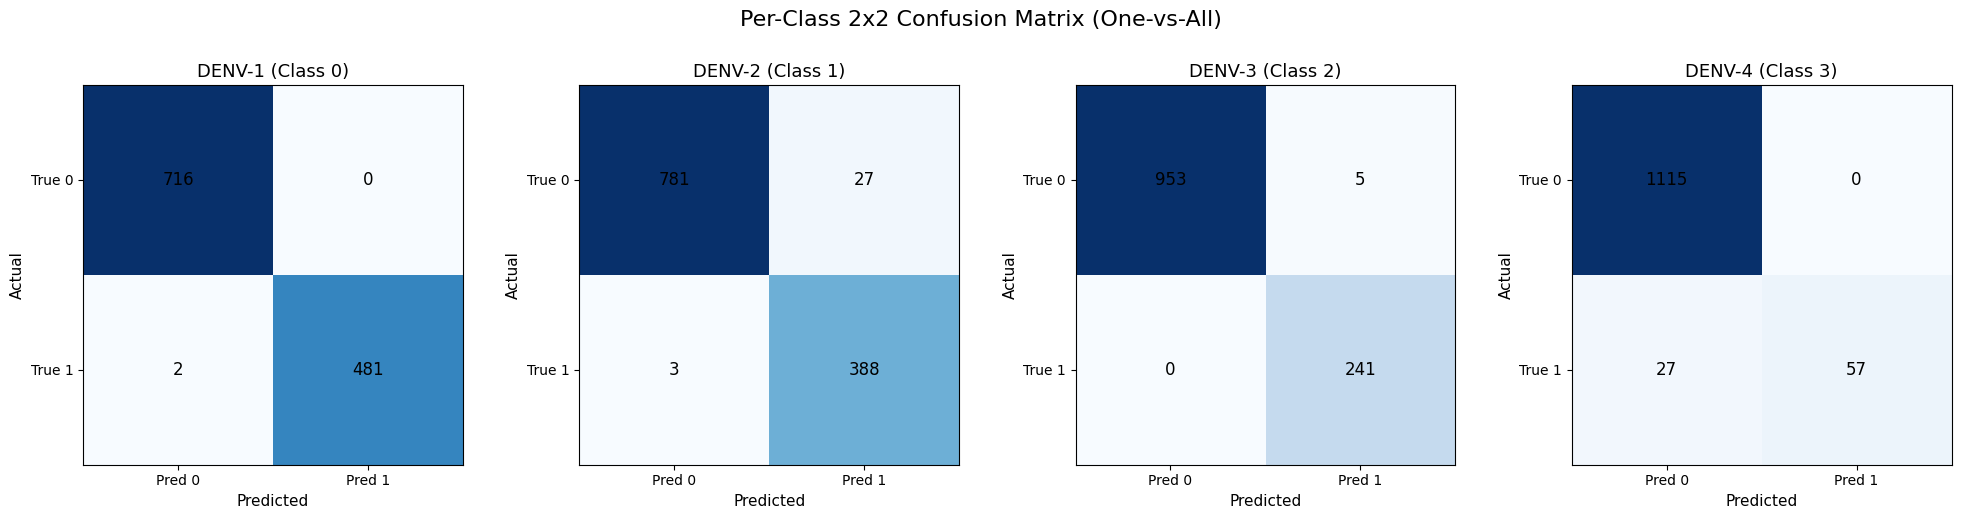

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

# Ensure y_test_labels and y_pred_labels are integer labels (not one-hot)
# e.g., y_test_labels = [0, 1, 2, 3, ...] and y_pred_labels = [0, 2, 1, ...]

# Get multilabel confusion matrices for each class (One-vs-All)
mcm = multilabel_confusion_matrix(y_test_labels, y_pred_labels, labels=[0, 1, 2, 3])

# Define class names
class_names = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']

# Create subplots for each class
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, ax in enumerate(axes):
    cm = mcm[i]
    im = ax.imshow(cm, cmap='Blues')
    ax.set_title(f'{class_names[i]} (Class {i})', fontsize=13)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Pred 0', 'Pred 1'])
    ax.set_yticklabels(['True 0', 'True 1'])
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_ylabel('Actual', fontsize=11)

    # Annotate each cell
    for j in range(2):
        for k in range(2):
            ax.text(k, j, str(cm[j, k]), va='center', ha='center', fontsize=12, color='black')

fig.suptitle('Per-Class 2x2 Confusion Matrix (One-vs-All)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()
sss